In [12]:
!pip install seiz-eeg
!pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu118.html


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
!pip install PyWavelets


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
# from google.colab import drive;
# drive.mount('/content/drive')

In [15]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from seiz_eeg.dataset import EEGDataset

# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [16]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = r"C:\Users\AT1123\Downloads\nml\nml_project\nml_project\data"

DATA_ROOT = Path(data_path)

DATA_ROOT =  Path("")

We have train segments, with labels...

In [17]:
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

"""def extract_patient_id(path):
    filename = path.split("/")[-1].split(".")[0]
    return filename[0:8]  # or [3:5] for 2-letter IDs

clips_tr["patient_id"] = clips_tr["signals_path"].apply(extract_patient_id)

display(clips_tr.iloc[100:115])"""

'def extract_patient_id(path):\n    filename = path.split("/")[-1].split(".")[0]\n    return filename[0:8]  # or [3:5] for 2-letter IDs\n\nclips_tr["patient_id"] = clips_tr["signals_path"].apply(extract_patient_id)\n\ndisplay(clips_tr.iloc[100:115])'

... and test segments, unlabeled.

In [18]:
clips_te = pd.read_parquet(DATA_ROOT / "test/segments.parquet")
#display(clips_te.head(10))

The EEG signals are stored in separate files at the corresponding `signals_path`, and each of them contains all data from a given session. Next section illustrate a convenient interface for loading and iterating on data.

In [19]:
"""display(
    pd.read_parquet(DATA_ROOT / "train/train" / clips_tr.iloc[0]["signals_path"]).iloc[
        12000:12015
    ]
)"""

'display(\n    pd.read_parquet(DATA_ROOT / "train/train" / clips_tr.iloc[0]["signals_path"]).iloc[\n        12000:12015\n    ]\n)'

In [20]:
"""from sklearn.model_selection import train_test_split

subject_to_segments = clips_tr.groupby("patient_id").indices
subject_ids = list(subject_to_segments.keys())

subject_labels = [
    clips_tr.iloc[subject_to_segments[s]]["label"].mode()[0] for s in subject_ids
]

train_ids, val_ids = train_test_split(
    subject_ids, test_size=0.2, stratify=subject_labels, random_state=42
)

train_indices = [i for sid in train_ids for i in subject_to_segments[sid]]
val_indices = [i for sid in val_ids for i in subject_to_segments[sid]]

train_clips = clips_tr.iloc[train_indices].reset_index(drop=True)
val_clips = clips_tr.iloc[val_indices].reset_index(drop=True)

print("Number of unique subjects:", len(subject_ids))
clips_tr["signals_path"].sample(10)
print(subject_ids)"""

'from sklearn.model_selection import train_test_split\n\nsubject_to_segments = clips_tr.groupby("patient_id").indices\nsubject_ids = list(subject_to_segments.keys())\n\nsubject_labels = [\n    clips_tr.iloc[subject_to_segments[s]]["label"].mode()[0] for s in subject_ids\n]\n\ntrain_ids, val_ids = train_test_split(\n    subject_ids, test_size=0.2, stratify=subject_labels, random_state=42\n)\n\ntrain_indices = [i for sid in train_ids for i in subject_to_segments[sid]]\nval_indices = [i for sid in val_ids for i in subject_to_segments[sid]]\n\ntrain_clips = clips_tr.iloc[train_indices].reset_index(drop=True)\nval_clips = clips_tr.iloc[val_indices].reset_index(drop=True)\n\nprint("Number of unique subjects:", len(subject_ids))\nclips_tr["signals_path"].sample(10)\nprint(subject_ids)'

## Preprocessing Methods


In [21]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

from scipy.signal import stft

def stft_transform(x: np.ndarray, fs=250, nperseg=128, noverlap=64) -> np.ndarray:
    features = []
    for ch in x.T:
        f, t, Zxx = signal.stft(ch, fs=fs, nperseg=nperseg, noverlap=noverlap)
        power = np.abs(Zxx) ** 2
        log_power = np.log1p(np.mean(power, axis=1))  # Mean over time
        features.append(log_power)
    return np.stack(features)  # [channels, freqs]


import numpy as np
import pywt

def wavelet_filtering(x: np.ndarray, wavelet: str = 'db4', level: int = 5) -> np.ndarray:
    """
    Extract selected wavelet detail coefficients as features.
    Input:
        x: [time_steps, channels] - EEG signal
    Output:
        [channels, features] - concatenated D2–D5 wavelet coeffs
    """
    features = []

    for i in range(x.shape[1]):
        signal = x[:, i]
        coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level)

        selected = coeffs[1:5]  # [D5, D4, D3, D2]
        flattened = np.concatenate(selected)
        features.append(flattened)

    return np.array(features)

def bandpower(x, fs=250):
    bands = [(0.5, 4), (4, 8), (8, 12), (12, 30)]
    result = []
    for ch in x.T:
        f, Pxx = welch(ch, fs=fs, nperseg=256)
        bandpowers = [np.log1p(np.trapezoid(Pxx[(f >= low) & (f < high)], f[(f >= low) & (f < high)])) for low, high in bands]
        result.append(bandpowers)
    return np.stack(result)

def combined_transform(x):
    """Concatenate wavelet + bandpower + STFT per channel"""
    x = signal.sosfiltfilt(bp_filter, x, axis=0)  # time-domain cleaning

    wvlt = wavelet_energy(x)    # shape: [channels, ~5]
    bp = bandpower(x)           # shape: [channels, 4]
    stft = stft_transform(x)    # shape: [channels, freqs]

    # Make sure all have matching shape[0] (channels)
    assert wvlt.shape[0] == bp.shape[0] == stft.shape[0]

    out = np.concatenate([wvlt, bp, stft], axis=1)  # along features
    return out  # final shape: [channels, features_combined]


# Enter the chosen transform
chosen_transform = stft_transform

## Loading the signals

For convenience, the `EEGDataset class` provides functionality for loading each segment and its label as `numpy` arrays.

You can provide an optional `signal_transform` function to preprocess the signals. In the example below, we have two bandpass filtering functions, which extract frequencies between 0.5Hz and 30Hz which are used in seizure analysis literature:

The `EEGDataset` class also allows to load all data in memory, instead of reading it from disk at every iteration. If your compute allows it, you can use `prefetch=True`.

In [22]:
# You can change the signal_transform, or remove it completely
dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=chosen_transform,
    prefetch=False,  # If your compute does not allow it, you can use `prefetch=False`
)

In [23]:
"""dataset_tr = EEGDataset(
    train_clips,
    signals_root=DATA_ROOT / "train/train",
    signal_transform=chosen_transform,
    prefetch=False,  # If your compute does not allow it, you can use `prefetch=False`
)

dataset_val = EEGDataset(
    val_clips,
    signals_root=DATA_ROOT / "train/train",
    signal_transform=chosen_transform,
    prefetch=False,  # If your compute does not allow it, you can use `prefetch=False`
)"""

'dataset_tr = EEGDataset(\n    train_clips,\n    signals_root=DATA_ROOT / "train/train",\n    signal_transform=chosen_transform,\n    prefetch=False,  # If your compute does not allow it, you can use `prefetch=False`\n)\n\ndataset_val = EEGDataset(\n    val_clips,\n    signals_root=DATA_ROOT / "train/train",\n    signal_transform=chosen_transform,\n    prefetch=False,  # If your compute does not allow it, you can use `prefetch=False`\n)'

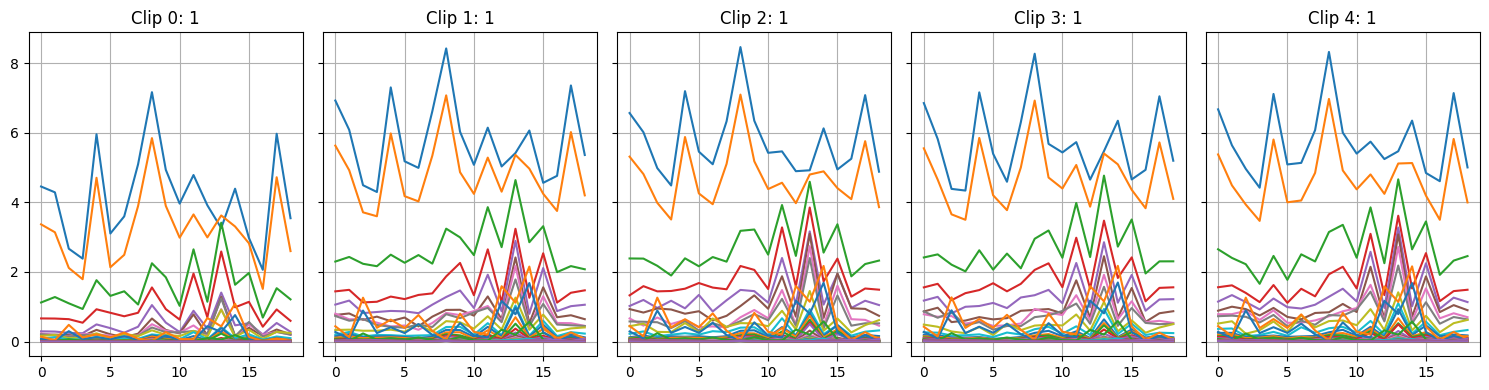

In [24]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i, (x, y) in enumerate(dataset_tr):
    if i > 4:
        break
    axes[i].plot(x)
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {y}"))

fig.tight_layout()
plt.show()

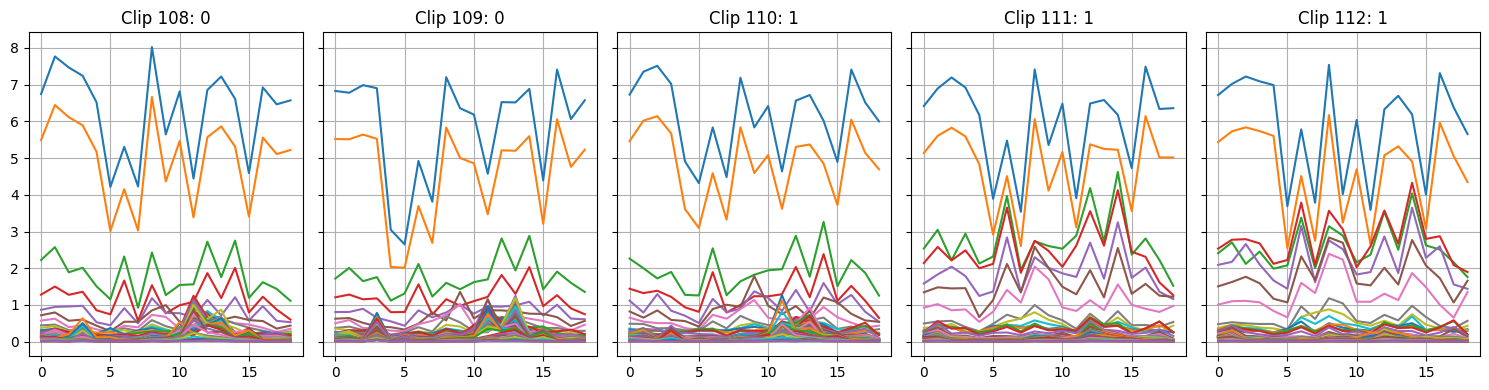

In [25]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i, ax in zip(range(108, 113), axes):
    x, y = dataset_tr[i]
    ax.plot(x)
    ax.grid()
    ax.set(title=(f"Clip {i}: {y}"))

fig.tight_layout()
plt.show()

## Compatibility with PyTorch

The `EEGDataset` class is compatible with [pytorch datasets and dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allow you to load batched data.

In [26]:
# Dependences
import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm

In [27]:
def seed_everything(seed: int):
    # Python random module
    random.seed(seed)
    # Numpy random module
    np.random.seed(seed)
    # Torch random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Set PYTHONHASHSEED environment variable for hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cudnn (may slow down your training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1)

In [28]:
loader_tr = DataLoader(dataset_tr, batch_size=2**8, shuffle=True)

There are 512 labeled training clips. Each clip has 354 time stamps. And there are 19 different channels.

## Graph Construction Methods


In [29]:
# Graph construction based on 1/distances

from torch_geometric.data import Data
import pandas as pd
import numpy as np
import pandas as pd
import torch
import pandas as pd
import torch

# Step 1: Load the CSV as an edge list
dist_df = pd.read_csv(DATA_ROOT/
    "distances_3d.csv"
)

# Step 2: Map electrode labels to indices
electrodes = sorted(set(dist_df['from']) | set(dist_df['to']))
node2idx = {node: i for i, node in enumerate(electrodes)}

# Step 3: Build edge_index and edge_attr
edges = []
weights = []

for f, t, d in zip(dist_df['from'], dist_df['to'], dist_df['distance']):
    if d > 0:
        u, v = node2idx[f], node2idx[t]
        weight = 1.0 / d
        # Add both directions for undirected graph
        edges.append([u, v])
        edges.append([v, u])
        weights.append(weight)
        weights.append(weight)

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(weights, dtype=torch.float)

# Final check
print(f"Edge index shape: {edge_index.shape}")       # Should be [2, num_edges * 2]
print("First 5 edges:\n", edge_index[:, :5])
print("First 5 edge weights:\n", edge_attr[:5])

c:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Edge index shape: torch.Size([2, 684])
First 5 edges:
 tensor([[7, 8, 7, 3, 7],
        [8, 7, 3, 7, 4]])
First 5 edge weights:
 tensor([1.6181, 1.6181, 1.6156, 1.6156, 0.9706])


In [30]:
# Graph construction based on k-nearest neighbor

from torch_geometric.data import Data
import pandas as pd
import numpy as np
import pandas as pd
import torch
import pandas as pd
import torch

# Step 1: Load the CSV as an edge list
dist_df = pd.read_csv(DATA_ROOT/
    "distances_3d.csv"
)

# Step 2: Map electrode labels to indices
electrodes = sorted(set(dist_df['from']) | set(dist_df['to']))
node2idx = {node: i for i, node in enumerate(electrodes)}

k = 5
edges_knn = []

for node in dist_df['from'].unique():
    sub = dist_df[dist_df['from'] == node].sort_values(by='distance').head(k)
    for _, row in sub.iterrows():
        u, v = node2idx[row['from']], node2idx[row['to']]
        edges_knn.append([u, v])
        edges_knn.append([v, u])  # undirected

edge_index_knn = torch.tensor(edges, dtype=torch.long).t().contiguous()

In [31]:
# Graph Construction based on mutual information

from sklearn.metrics import mutual_info_score
import numpy as np

def compute_mi_matrix(X, bins=16):
    """
    Compute pairwise mutual information between EEG channels.
    X: shape [channels, time]
    """
    n = X.shape[0]
    mi_matrix = np.zeros((n, n))

    # Discretize signals per channel
    X_disc = np.floor((X - X.min(axis=1, keepdims=True)) /
                      (X.max(axis=1, keepdims=True) - X.min(axis=1, keepdims=True) + 1e-8) * (bins - 1)).astype(int)

    for i in range(n):
        for j in range(i, n):
            mi = mutual_info_score(X_disc[i], X_disc[j])
            mi_matrix[i, j] = mi
            mi_matrix[j, i] = mi  # symmetric

    # Normalize the MI matrix
    for i in range(n):
        for j in range(n):
            mi_matrix[i, j] /= min(mi_matrix[i, i], mi_matrix[j, j]) + 1e-8

    return mi_matrix

def average_mi_over_dataset(dataset, n_segments=100):
    x0, _ = dataset[0]
    n_channels = x0.shape[0]
    mi_sum = np.zeros((n_channels, n_channels))

    for i in range(min(n_segments, len(dataset))):
        x_np, _ = dataset[i]
        mi_sum += compute_mi_matrix(x_np)

    return mi_sum / n_segments


def mi_to_graph(mi_matrix, k=4):
    edge_list = []
    edge_weights = []

    for i in range(mi_matrix.shape[0]):
        top_k = np.argsort(mi_matrix[i])[-k:]
        for j in top_k:
            if i != j:
                edge_list.append([i, j])
                edge_list.append([j, i])
                edge_weights.append(mi_matrix[i, j])
                edge_weights.append(mi_matrix[i, j])  # symmetric

    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_weights, dtype=torch.float)
    return edge_index, edge_attr

# Compute MI matrix
mi_matrix = average_mi_over_dataset(dataset_tr, n_segments=100)

# Build graph with top-8 MI neighbors per node
edge_index, edge_attr = mi_to_graph(mi_matrix, k=19)

# Final check
print("Edge index shape:", edge_index.shape)
print("Edge attr shape:", edge_attr.shape)

Edge index shape: torch.Size([2, 684])
Edge attr shape: torch.Size([684])


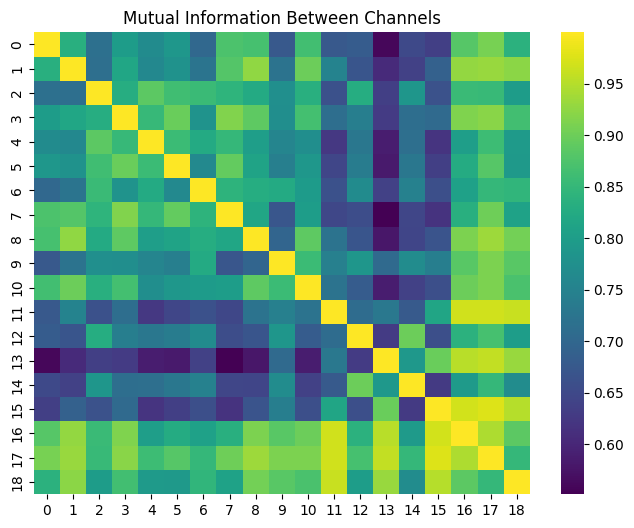

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(mi_matrix, cmap="viridis")
plt.title("Mutual Information Between Channels")
plt.savefig("mutual_info.png")
plt.show()

## Define the Models

In [33]:
from torch_geometric.data import Data

def create_graph_data(x_batch, y_batch, edge_index, edge_attr):
    graphs = []

    for x, y in zip(x_batch, y_batch):
        x_tensor = torch.tensor(x, dtype=torch.float)        # [num_nodes, num_features]
        y_tensor = torch.tensor([y], dtype=torch.float)       # [1] or [1,1] for BCE/MSE
        graph = Data(x=x_tensor, edge_index=edge_index, edge_attr=edge_attr, y=y_tensor)
        graphs.append(graph)

    return graphs

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader

class EEG_GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.classifier = nn.Linear(out_channels, 1)


    def forward(self, x, edge_index, edge_weight, batch):
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        x = global_mean_pool(x, batch)  # Graph-level representation
        x = self.classifier(x)
        return x  # [batch_size, 1]

In [35]:
from torch_geometric.nn import BatchNorm

class EEG_GCN_v2(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.bn2 = BatchNorm(out_channels)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = global_mean_pool(x, batch)
        return self.classifier(x)

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import DataLoader

class EEG_SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.classifier = nn.Linear(out_channels, 1)


    def forward(self, x, edge_index, edge_weight, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Graph-level representation
        x = self.classifier(x)
        return x  # [batch_size, 1]

In [37]:
from torch_geometric.nn import BatchNorm

class EEG_SAGE_v2(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.bn2 = BatchNorm(out_channels)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = global_mean_pool(x, batch)
        return self.classifier(x)

In [38]:
class GIN_with_edge(torch.nn.Module):
    def __init__(self, input_dim=19, hidden_dim=64, dropout=0.2, edge_dim = 1):
        super().__init__()
        
        self.conv1 = GINEConv(
            Sequential(
                Linear(input_dim,  hidden_dim),
                BatchNorm1d(hidden_dim), ReLU(),
                #Dropout(0.2),
                Linear(hidden_dim, hidden_dim), ReLU()
            ),
            edge_dim=edge_dim,
        )
        
        self.conv2 = GINEConv(
            Sequential(
                Linear(hidden_dim, hidden_dim),
                BatchNorm1d(hidden_dim), ReLU(),
                # Dropout(0.2),
                Linear(hidden_dim, hidden_dim), ReLU()
            ),
            edge_dim=edge_dim,
        )

        self.lin1 = Linear(hidden_dim*3, hidden_dim)
        self.lin2 = Linear(hidden_dim, 1)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_attr, batch):

        # Randomly drop edges
        if self.training:       
            E = edge_index.size(1)
            p = 0.2
            mask = torch.rand(E, device=edge_index.device) >= p
            edge_index = edge_index[:, mask]
            edge_attr = edge_attr[mask]
            
        h1 = self.conv1(x, edge_index, edge_attr)
        h2 = self.conv2(h1, edge_index, edge_attr)

        h_sum  = global_add_pool(h2, batch)
        h_mean = global_mean_pool(h2, batch)
        h_max  = global_max_pool(h2, batch)
        h = torch.cat([h_sum, h_mean, h_max], dim=1)
        
        h = self.lin1(h).relu()
        h = F.dropout(h, p=0.2, training=self.training)
        h = self.lin2(h).squeeze(1)

        return h

In [39]:

import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool

class STGNN_EEG(nn.Module):
    def __init__(self, time_steps, temporal_out=32, gcn_hidden=64):
        super().__init__()

        # Temporal encoder: Conv1D over [T] dimension of each node
        self.temporal = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, stride=2, padding=3),  # [B*19, 1, T] → [B*19, 16, T']
            nn.ReLU(),
            nn.Conv1d(16, temporal_out, kernel_size=5, stride=2, padding=2),  # [B*19, 32, T'']
            nn.ReLU()
        )

        self.gcn1 = GCNConv(temporal_out, gcn_hidden)
        self.gcn2 = GCNConv(gcn_hidden, gcn_hidden)

        self.classifier = nn.Sequential(
            nn.Linear(2 * gcn_hidden, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)  # Binary classification
        )

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch
        # Input x shape: [B*19, T] → reshape to [B*19, 1, T]
        x = x.unsqueeze(1)
        x = self.temporal(x)  # [B*19, C, T']
        x = x.mean(dim=2)     # Temporal average → [B*19, temporal_out]

        x = self.gcn1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = self.gcn2(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)

        # Spatio-temporal pooling
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        x = torch.cat([x_mean, x_max], dim=1)

        return self.classifier(x)  # [B, 1]


In [40]:
from torch_geometric.nn import ChebConv, global_mean_pool

import torch
import torch.nn.functional as F
import torch.nn as nn

class EEG_ChebNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, K=3):
        super().__init__()
        self.conv1 = ChebConv(in_channels, hidden_channels, K=K)
        self.conv2 = ChebConv(hidden_channels, hidden_channels, K=K)
        self.classifier = nn.Linear(hidden_channels, out_channels)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index, edge_weight, batch):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.dropout(x)

        x = global_mean_pool(x, batch)
        return self.classifier(x)

In [41]:
from torch_geometric.nn import GlobalAttention

class EEG_ChebNet_Attn(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, K=3):
        super().__init__()
        self.conv1 = ChebConv(in_channels, hidden_channels, K=K)
        self.conv2 = ChebConv(hidden_channels, hidden_channels, K=K)

        # Global attention pooling with learnable gate
        self.attn_pool = GlobalAttention(gate_nn=nn.Sequential(
            nn.Linear(hidden_channels, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        ))

        self.classifier = nn.Linear(hidden_channels, out_channels)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index, edge_weight, batch):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.attn_pool(x, batch)
        return self.classifier(x)


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import ChebConv, global_mean_pool

class EEG_ChebNet_Res(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, K=3):
        super().__init__()
        self.conv1 = ChebConv(in_channels, hidden_channels, K=K)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.conv2 = ChebConv(hidden_channels, hidden_channels, K=K)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.classifier = nn.Linear(hidden_channels, out_channels)
        self.dropout = nn.Dropout(0.3)

        # Project input to match hidden_channels for residual path (if needed)
        self.res_proj = nn.Linear(in_channels, hidden_channels) if in_channels != hidden_channels else nn.Identity()

    def forward(self, x, edge_index, edge_weight, batch):
        res = self.res_proj(x)  # Project for residual
        x = self.conv1(x, edge_index, edge_weight)
        x = self.bn1(x)
        x = F.relu(x + res)  # Residual connection
        x = self.dropout(x)

        res2 = x  # second residual
        x = self.conv2(x, edge_index, edge_weight)
        x = self.bn2(x)
        x = F.relu(x + res2)  # Second residual
        x = self.dropout(x)

        x = global_mean_pool(x, batch)
        return self.classifier(x)

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import ChebConv, GlobalAttention, BatchNorm

class EEG_ChebNet_ResAttn(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, K=3):
        super().__init__()
        self.conv1 = ChebConv(in_channels, hidden_channels, K=K)
        self.bn1 = BatchNorm(hidden_channels)
        self.res1 = nn.Linear(in_channels, hidden_channels) if in_channels != hidden_channels else nn.Identity()

        self.conv2 = ChebConv(hidden_channels, hidden_channels, K=K)
        self.bn2 = BatchNorm(hidden_channels)

        self.attn_pool = GlobalAttention(gate_nn=nn.Sequential(
            nn.Linear(hidden_channels, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        ))

        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight, batch):
        # First residual block
        res1 = self.res1(x)
        x = self.conv1(x, edge_index, edge_weight)
        x = self.bn1(x)
        x = F.relu(x + res1)
        x = self.dropout(x)

        # Second residual block
        res2 = x
        x = self.conv2(x, edge_index, edge_weight)
        x = self.bn2(x)
        x = F.relu(x + res2)
        x = self.dropout(x)

        # Attention-based global pooling
        x = self.attn_pool(x, batch)
        return self.classifier(x)

In [44]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

print(torch.version.cuda)

Using device: cuda
11.8


## Convert the dataset

In [45]:
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm import tqdm

# === Step 1: Convert (x_numpy, y_numpy) tuples to Data objects ===
# Assumes edge_index and edge_attr are defined globally

for x_np, y_np in tqdm(dataset_tr, desc="Converting dataset"):
    print("Original x_np shape:", x_np.shape)  # likely [354, 19]
    x = torch.tensor(x_np.T, dtype=torch.float)  # we expect [19, 354]
    print("Transposed x shape:", x.shape)
    print("y shape:", torch.tensor([y_np], dtype=torch.float).shape)
    ...
    break  # just inspect one sample for now

new_dataset = []
for x_np, y_np in tqdm(dataset_tr, desc="Converting dataset"):
    x = torch.tensor(x_np, dtype=torch.float)  # ← TRANSPOSE added here!
    y = torch.tensor([y_np], dtype=torch.float)
    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    new_dataset.append(graph)

dataset_tr = new_dataset
loader_tr = DataLoader(dataset_tr, batch_size=2**8, shuffle=True)

Converting dataset:   0%|          | 0/12993 [00:00<?, ?it/s]


Original x_np shape: (19, 65)
Transposed x shape: torch.Size([65, 19])
y shape: torch.Size([1])


Converting dataset: 100%|██████████| 12993/12993 [00:55<00:00, 234.87it/s]


In [46]:
"""import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm import tqdm

# === Step 1: Convert (x_numpy, y_numpy) tuples to Data objects ===
# Assumes edge_index and edge_attr are defined globally

for x_np, y_np in tqdm(dataset_tr, desc="Converting dataset"):
    print("Original x_np shape:", x_np.shape)  # likely [354, 19]
    x = torch.tensor(x_np.T, dtype=torch.float)  # we expect [19, 354]
    print("Transposed x shape:", x.shape)
    print("y shape:", torch.tensor([y_np], dtype=torch.float).shape)
    ...
    break  # just inspect one sample for now

new_dataset = []
for x_np, y_np in tqdm(dataset_tr, desc="Converting dataset"):
    x = torch.tensor(x_np, dtype=torch.float)  # ← TRANSPOSE added here!
    y = torch.tensor([y_np], dtype=torch.float)
    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    new_dataset.append(graph)

dataset_tr = new_dataset
loader_tr = DataLoader(dataset_tr, batch_size=2**8, shuffle=True)

new_dataset = []
for x_np, y_np in tqdm(dataset_val, desc="Converting dataset"):
    x = torch.tensor(x_np, dtype=torch.float)  # ← TRANSPOSE added here!
    y = torch.tensor([y_np], dtype=torch.float)
    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    new_dataset.append(graph)

dataset_val = new_dataset
loader_val = DataLoader(dataset_val, batch_size=2**8, shuffle=True)"""

'import torch\nimport torch.nn as nn\nfrom torch_geometric.data import Data\nfrom torch_geometric.loader import DataLoader\nfrom tqdm import tqdm\n\n# === Step 1: Convert (x_numpy, y_numpy) tuples to Data objects ===\n# Assumes edge_index and edge_attr are defined globally\n\nfor x_np, y_np in tqdm(dataset_tr, desc="Converting dataset"):\n    print("Original x_np shape:", x_np.shape)  # likely [354, 19]\n    x = torch.tensor(x_np.T, dtype=torch.float)  # we expect [19, 354]\n    print("Transposed x shape:", x.shape)\n    print("y shape:", torch.tensor([y_np], dtype=torch.float).shape)\n    ...\n    break  # just inspect one sample for now\n\nnew_dataset = []\nfor x_np, y_np in tqdm(dataset_tr, desc="Converting dataset"):\n    x = torch.tensor(x_np, dtype=torch.float)  # ← TRANSPOSE added here!\n    y = torch.tensor([y_np], dtype=torch.float)\n    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)\n    new_dataset.append(graph)\n\ndataset_tr = new_dataset\nloader_tr = Da

## Some Prints for debugging

In [47]:
 for batch in loader_tr:
    print("Batch.x shape:", batch.x.shape)             # should be [B×19, 354]
    print("Batch.edge_index shape:", batch.edge_index.shape)
    print("Batch.edge_attr shape:", batch.edge_attr.shape)
    print("Batch.batch shape:", batch.batch.shape)     # [B×19]
    print("Batch.y shape:", batch.y.shape)             # [B, 1]
    break

Batch.x shape: torch.Size([4864, 65])
Batch.edge_index shape: torch.Size([2, 175104])
Batch.edge_attr shape: torch.Size([175104])
Batch.batch shape: torch.Size([4864])
Batch.y shape: torch.Size([256])


In [48]:
from collections import Counter

# Extract labels
labels = [int(graph.y.item()) for graph in dataset_tr]

# Count occurrences
label_counts = Counter(labels)

# Print results
print("Class distribution:")
for label, count in label_counts.items():
    print(f"Class {label}: {count} samples")

# Optional: class ratio
total = sum(label_counts.values())
print(f"Percentage class 0: {label_counts[0] / total * 100:.2f}%")
print(f"Percentage class 1: {label_counts[1] / total * 100:.2f}%")


Class distribution:
Class 1: 2517 samples
Class 0: 10476 samples
Percentage class 0: 80.63%
Percentage class 1: 19.37%


## Train

In [49]:
experiment = "chebnetattn-stft-mi"

In [50]:
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm import tqdm

# === Step 1: Class distribution for pos_weight ===
labels = [int(graph.y.item()) for graph in dataset_tr]
label_counts = Counter(labels)
print("Class distribution:", label_counts)

pos_weight = torch.tensor([label_counts[0] / label_counts[1]]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# === Step 2: Stratified train/val split
train_set, val_set = train_test_split(
    dataset_tr, test_size=0.2, stratify=labels, random_state=42
)
loader_tr = DataLoader(train_set, batch_size=2**8, shuffle=True)
loader_val = DataLoader(val_set, batch_size=2**8, shuffle=False)


# === Step 3: Model, optimizer
in_channels = dataset_tr[0].x.shape[1]
hidden_channels = 32
out_channels = 1

#model = EEG_GCN_v2(in_channels, hidden_channels, out_channels).to(device)
#model = EEG_ChebNet(in_channels, hidden_channels, out_channels).to(device)
#model_SAGE = EEG_SAGE_v2(in_channels, hidden_channels, out_channels).to(device)

model = EEG_ChebNet_Attn(in_channels, hidden_channels, out_channels).to(device)

#model = EEG_ChebNet_Res(in_channels, hidden_channels, out_channels).to(device)
#model = EEG_ChebNet_ResAttn(in_channels, hidden_channels, out_channels).to(device)

#model = EEG_TAGNet_Res(in_channels, hidden_channels, out_channels).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=4e-4)

# === Step 4: Training config
num_epochs = 400
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1s, val_f1s = [], []

# === Save best model by F1
best_val_f1 = 0.0
best_model_path = f"{experiment}_best_model.pt"

# === Early Stop
early_stop_counter = 0
patience = 150

# === Step 5: Training loop
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=50, verbose=True)

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_targets = [], []

    pbar = tqdm(loader_tr, desc=f"Epoch {epoch+1} [train]", leave=False)
    for batch in pbar:
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
#        logits = model_SAGE(batch.x, batch.edge_index, batch.edge_index, batch.batch)
        loss = criterion(logits.view(-1), batch.y.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        probs = torch.sigmoid(logits).view(-1)
        preds = probs > 0.5
        targets = batch.y.view(-1).bool()

        correct += (preds == targets).sum().item()
        total += targets.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

    train_loss = total_loss / len(loader_tr)
    train_acc = correct / total
    train_f1 = f1_score(all_targets, all_preds, average = 'macro')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_f1s.append(train_f1)

    # === Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_preds, val_targets = [], []

    with torch.no_grad():
        for batch in loader_val:
            batch = batch.to(device)
            logits = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            loss = criterion(logits.view(-1), batch.y.view(-1))
            val_loss += loss.item()

            probs = torch.sigmoid(logits).view(-1)
            preds = probs > 0.5
            targets = batch.y.view(-1).bool()

            val_correct += (preds == targets).sum().item()
            val_total += targets.size(0)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())

    val_loss /= len(loader_val)
    val_acc = val_correct / val_total
    val_f1 = f1_score(val_targets, val_preds, average = 'macro')
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)

    scheduler.step(val_f1)

    # === Save best model by val F1
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved new best model (Val F1: {val_f1:.4f})")

        early_stop_counter = 0

    else:
      early_stop_counter += 1
      if early_stop_counter >= patience:
          print(" Early stopping")
          break

    print(f"Epoch {epoch+1} — "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}%, F1: {train_f1:.4f} — "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}%, F1: {val_f1:.4f}")

Class distribution: Counter({0: 10476, 1: 2517})


c:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)
c:\Users\hsnsa\anaconda3\envs\networkml\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Saved new best model (Val F1: 0.1816)
Epoch 1 — Train Loss: 1.2671, Acc: 28.48%, F1: 0.2848 — Val Loss: 1.1034, Acc: 20.74%, F1: 0.1816


Saved new best model (Val F1: 0.6241)
Epoch 2 — Train Loss: 1.0560, Acc: 56.89%, F1: 0.5218 — Val Loss: 0.9923, Acc: 70.03%, F1: 0.6241


Epoch 3 — Train Loss: 0.9959, Acc: 69.00%, F1: 0.6087 — Val Loss: 0.9611, Acc: 69.53%, F1: 0.6216


Epoch 4 — Train Loss: 0.9662, Acc: 71.14%, F1: 0.6248 — Val Loss: 0.9428, Acc: 69.33%, F1: 0.6206


Epoch 5 — Train Loss: 0.9528, Acc: 71.28%, F1: 0.6314 — Val Loss: 0.9247, Acc: 68.56%, F1: 0.6212


Saved new best model (Val F1: 0.6361)
Epoch 6 — Train Loss: 0.9307, Acc: 72.43%, F1: 0.6426 — Val Loss: 0.9081, Acc: 70.57%, F1: 0.6361


Saved new best model (Val F1: 0.6497)
Epoch 7 — Train Loss: 0.9195, Acc: 71.98%, F1: 0.6400 — Val Loss: 0.8979, Acc: 72.53%, F1: 0.6497


Epoch 8 — Train Loss: 0.9105, Acc: 72.88%, F1: 0.6506 — Val Loss: 0.8900, Acc: 67.56%, F1: 0.6206


Saved new best model (Val F1: 0.6539)
Epoch 9 — Train Loss: 0.8935, Acc: 72.62%, F1: 0.6515 — Val Loss: 0.8710, Acc: 72.03%, F1: 0.6539


Saved new best model (Val F1: 0.6717)
Epoch 10 — Train Loss: 0.8874, Acc: 72.57%, F1: 0.6505 — Val Loss: 0.8645, Acc: 74.64%, F1: 0.6717


Epoch 11 — Train Loss: 0.8804, Acc: 73.47%, F1: 0.6576 — Val Loss: 0.8616, Acc: 68.76%, F1: 0.6342


Epoch 12 — Train Loss: 0.8736, Acc: 72.36%, F1: 0.6530 — Val Loss: 0.8481, Acc: 73.41%, F1: 0.6677


Epoch 13 — Train Loss: 0.8712, Acc: 73.58%, F1: 0.6613 — Val Loss: 0.8455, Acc: 71.03%, F1: 0.6511


Epoch 14 — Train Loss: 0.8672, Acc: 73.41%, F1: 0.6627 — Val Loss: 0.8528, Acc: 68.41%, F1: 0.6340


Epoch 15 — Train Loss: 0.8576, Acc: 74.72%, F1: 0.6753 — Val Loss: 0.8379, Acc: 71.26%, F1: 0.6539


Saved new best model (Val F1: 0.6775)
Epoch 16 — Train Loss: 0.8478, Acc: 74.93%, F1: 0.6779 — Val Loss: 0.8290, Acc: 74.14%, F1: 0.6775


Saved new best model (Val F1: 0.6818)
Epoch 17 — Train Loss: 0.8451, Acc: 73.99%, F1: 0.6699 — Val Loss: 0.8271, Acc: 74.68%, F1: 0.6818


Epoch 18 — Train Loss: 0.8349, Acc: 75.25%, F1: 0.6814 — Val Loss: 0.8273, Acc: 68.53%, F1: 0.6368


Epoch 19 — Train Loss: 0.8321, Acc: 75.38%, F1: 0.6824 — Val Loss: 0.8132, Acc: 72.18%, F1: 0.6656


Saved new best model (Val F1: 0.7244)
Epoch 20 — Train Loss: 0.8172, Acc: 76.16%, F1: 0.6925 — Val Loss: 0.8153, Acc: 80.65%, F1: 0.7244


Epoch 21 — Train Loss: 0.8223, Acc: 75.38%, F1: 0.6857 — Val Loss: 0.7944, Acc: 78.68%, F1: 0.7144


Epoch 22 — Train Loss: 0.8075, Acc: 76.46%, F1: 0.6961 — Val Loss: 0.7882, Acc: 75.95%, F1: 0.6952


Epoch 23 — Train Loss: 0.8032, Acc: 76.94%, F1: 0.7007 — Val Loss: 0.7866, Acc: 76.99%, F1: 0.7045


Epoch 24 — Train Loss: 0.7959, Acc: 77.94%, F1: 0.7087 — Val Loss: 0.7771, Acc: 74.80%, F1: 0.6892


Saved new best model (Val F1: 0.7325)
Epoch 25 — Train Loss: 0.7877, Acc: 77.42%, F1: 0.7058 — Val Loss: 0.7677, Acc: 80.45%, F1: 0.7325


Saved new best model (Val F1: 0.7425)
Epoch 26 — Train Loss: 0.7735, Acc: 78.28%, F1: 0.7136 — Val Loss: 0.7564, Acc: 81.45%, F1: 0.7425


Epoch 27 — Train Loss: 0.7699, Acc: 78.58%, F1: 0.7164 — Val Loss: 0.7510, Acc: 77.38%, F1: 0.7115


Epoch 28 — Train Loss: 0.7737, Acc: 78.05%, F1: 0.7110 — Val Loss: 0.7547, Acc: 77.76%, F1: 0.7136


Saved new best model (Val F1: 0.7489)
Epoch 29 — Train Loss: 0.7646, Acc: 78.83%, F1: 0.7195 — Val Loss: 0.7412, Acc: 81.84%, F1: 0.7489


Epoch 30 — Train Loss: 0.7657, Acc: 79.05%, F1: 0.7218 — Val Loss: 0.7429, Acc: 81.95%, F1: 0.7475


Epoch 31 — Train Loss: 0.7525, Acc: 79.26%, F1: 0.7244 — Val Loss: 0.7327, Acc: 79.92%, F1: 0.7342


Epoch 32 — Train Loss: 0.7516, Acc: 79.90%, F1: 0.7303 — Val Loss: 0.7253, Acc: 78.68%, F1: 0.7249


Saved new best model (Val F1: 0.7574)
Epoch 33 — Train Loss: 0.7405, Acc: 79.62%, F1: 0.7299 — Val Loss: 0.7336, Acc: 82.99%, F1: 0.7574


Epoch 34 — Train Loss: 0.7436, Acc: 79.92%, F1: 0.7326 — Val Loss: 0.7198, Acc: 80.26%, F1: 0.7381


Epoch 35 — Train Loss: 0.7371, Acc: 80.07%, F1: 0.7326 — Val Loss: 0.7172, Acc: 81.57%, F1: 0.7470


Saved new best model (Val F1: 0.7609)
Epoch 36 — Train Loss: 0.7346, Acc: 80.14%, F1: 0.7344 — Val Loss: 0.7121, Acc: 82.92%, F1: 0.7609


Epoch 37 — Train Loss: 0.7319, Acc: 80.08%, F1: 0.7352 — Val Loss: 0.7038, Acc: 81.99%, F1: 0.7538


Epoch 38 — Train Loss: 0.7318, Acc: 80.05%, F1: 0.7318 — Val Loss: 0.7041, Acc: 79.11%, F1: 0.7295


Epoch 39 — Train Loss: 0.7223, Acc: 80.58%, F1: 0.7396 — Val Loss: 0.7000, Acc: 81.84%, F1: 0.7530


Epoch 40 — Train Loss: 0.7210, Acc: 81.13%, F1: 0.7423 — Val Loss: 0.7052, Acc: 77.49%, F1: 0.7162


Epoch 41 — Train Loss: 0.7221, Acc: 80.23%, F1: 0.7357 — Val Loss: 0.6962, Acc: 80.45%, F1: 0.7413


Epoch 42 — Train Loss: 0.7114, Acc: 81.27%, F1: 0.7459 — Val Loss: 0.7057, Acc: 78.41%, F1: 0.7249


Epoch 43 — Train Loss: 0.7158, Acc: 80.36%, F1: 0.7364 — Val Loss: 0.6945, Acc: 81.76%, F1: 0.7512


Epoch 44 — Train Loss: 0.7159, Acc: 80.85%, F1: 0.7393 — Val Loss: 0.6933, Acc: 81.26%, F1: 0.7480


Epoch 45 — Train Loss: 0.7111, Acc: 80.63%, F1: 0.7406 — Val Loss: 0.6915, Acc: 79.68%, F1: 0.7356


Saved new best model (Val F1: 0.7638)
Epoch 46 — Train Loss: 0.7029, Acc: 81.06%, F1: 0.7436 — Val Loss: 0.6819, Acc: 82.99%, F1: 0.7638


Epoch 47 — Train Loss: 0.7031, Acc: 81.53%, F1: 0.7469 — Val Loss: 0.6771, Acc: 82.03%, F1: 0.7547


Saved new best model (Val F1: 0.7695)
Epoch 48 — Train Loss: 0.6986, Acc: 81.19%, F1: 0.7459 — Val Loss: 0.6741, Acc: 83.69%, F1: 0.7695


Epoch 49 — Train Loss: 0.7055, Acc: 81.40%, F1: 0.7466 — Val Loss: 0.6708, Acc: 82.61%, F1: 0.7622


Epoch 50 — Train Loss: 0.6972, Acc: 81.73%, F1: 0.7503 — Val Loss: 0.6794, Acc: 79.45%, F1: 0.7366


Saved new best model (Val F1: 0.7746)
Epoch 51 — Train Loss: 0.6975, Acc: 81.20%, F1: 0.7465 — Val Loss: 0.6814, Acc: 84.57%, F1: 0.7746


Epoch 52 — Train Loss: 0.7012, Acc: 81.83%, F1: 0.7501 — Val Loss: 0.6786, Acc: 78.61%, F1: 0.7265


Epoch 53 — Train Loss: 0.6978, Acc: 81.60%, F1: 0.7491 — Val Loss: 0.6628, Acc: 82.57%, F1: 0.7616


Epoch 54 — Train Loss: 0.6880, Acc: 81.38%, F1: 0.7473 — Val Loss: 0.6705, Acc: 81.80%, F1: 0.7537


Epoch 55 — Train Loss: 0.6984, Acc: 81.57%, F1: 0.7483 — Val Loss: 0.6686, Acc: 82.69%, F1: 0.7585


Epoch 56 — Train Loss: 0.6850, Acc: 81.86%, F1: 0.7530 — Val Loss: 0.6573, Acc: 83.57%, F1: 0.7694


Saved new best model (Val F1: 0.7803)
Epoch 57 — Train Loss: 0.6854, Acc: 82.10%, F1: 0.7553 — Val Loss: 0.6617, Acc: 84.92%, F1: 0.7803


Epoch 58 — Train Loss: 0.6820, Acc: 82.23%, F1: 0.7570 — Val Loss: 0.6578, Acc: 82.45%, F1: 0.7606


Epoch 59 — Train Loss: 0.6801, Acc: 82.21%, F1: 0.7550 — Val Loss: 0.6634, Acc: 83.76%, F1: 0.7722


Epoch 60 — Train Loss: 0.6864, Acc: 82.48%, F1: 0.7586 — Val Loss: 0.6614, Acc: 82.15%, F1: 0.7583


Epoch 61 — Train Loss: 0.6868, Acc: 81.55%, F1: 0.7496 — Val Loss: 0.6581, Acc: 84.69%, F1: 0.7786


Saved new best model (Val F1: 0.7825)
Epoch 62 — Train Loss: 0.6772, Acc: 82.34%, F1: 0.7584 — Val Loss: 0.6579, Acc: 85.19%, F1: 0.7825


Epoch 63 — Train Loss: 0.6730, Acc: 82.66%, F1: 0.7600 — Val Loss: 0.6519, Acc: 82.34%, F1: 0.7587


Epoch 64 — Train Loss: 0.6747, Acc: 81.63%, F1: 0.7500 — Val Loss: 0.6513, Acc: 83.49%, F1: 0.7691


Epoch 65 — Train Loss: 0.6726, Acc: 82.54%, F1: 0.7592 — Val Loss: 0.6502, Acc: 83.69%, F1: 0.7695


Epoch 66 — Train Loss: 0.6820, Acc: 82.62%, F1: 0.7600 — Val Loss: 0.6457, Acc: 82.45%, F1: 0.7639


Saved new best model (Val F1: 0.7855)
Epoch 67 — Train Loss: 0.6685, Acc: 82.24%, F1: 0.7571 — Val Loss: 0.6552, Acc: 85.53%, F1: 0.7855


Epoch 68 — Train Loss: 0.6669, Acc: 82.60%, F1: 0.7616 — Val Loss: 0.6438, Acc: 82.65%, F1: 0.7639


Epoch 69 — Train Loss: 0.6636, Acc: 82.66%, F1: 0.7600 — Val Loss: 0.6458, Acc: 81.99%, F1: 0.7590


Epoch 70 — Train Loss: 0.6725, Acc: 82.39%, F1: 0.7589 — Val Loss: 0.6390, Acc: 83.88%, F1: 0.7731


Epoch 71 — Train Loss: 0.6710, Acc: 82.89%, F1: 0.7633 — Val Loss: 0.6435, Acc: 84.96%, F1: 0.7813


Epoch 72 — Train Loss: 0.6596, Acc: 83.05%, F1: 0.7659 — Val Loss: 0.6492, Acc: 84.19%, F1: 0.7762


Epoch 73 — Train Loss: 0.6566, Acc: 83.20%, F1: 0.7673 — Val Loss: 0.6339, Acc: 84.57%, F1: 0.7798


Epoch 74 — Train Loss: 0.6556, Acc: 82.97%, F1: 0.7643 — Val Loss: 0.6323, Acc: 83.49%, F1: 0.7714


Epoch 75 — Train Loss: 0.6544, Acc: 83.30%, F1: 0.7681 — Val Loss: 0.6334, Acc: 83.65%, F1: 0.7715


Saved new best model (Val F1: 0.7889)
Epoch 76 — Train Loss: 0.6582, Acc: 82.83%, F1: 0.7638 — Val Loss: 0.6390, Acc: 85.96%, F1: 0.7889


Epoch 77 — Train Loss: 0.6634, Acc: 83.10%, F1: 0.7652 — Val Loss: 0.6430, Acc: 84.15%, F1: 0.7763


Epoch 78 — Train Loss: 0.6531, Acc: 83.16%, F1: 0.7675 — Val Loss: 0.6390, Acc: 85.38%, F1: 0.7862


Epoch 79 — Train Loss: 0.6512, Acc: 83.22%, F1: 0.7670 — Val Loss: 0.6356, Acc: 85.15%, F1: 0.7826


Epoch 80 — Train Loss: 0.6503, Acc: 83.33%, F1: 0.7680 — Val Loss: 0.6303, Acc: 84.42%, F1: 0.7797


Epoch 81 — Train Loss: 0.6520, Acc: 83.47%, F1: 0.7700 — Val Loss: 0.6274, Acc: 82.84%, F1: 0.7656


Epoch 82 — Train Loss: 0.6537, Acc: 82.28%, F1: 0.7579 — Val Loss: 0.6305, Acc: 82.99%, F1: 0.7672


Epoch 83 — Train Loss: 0.6429, Acc: 83.70%, F1: 0.7735 — Val Loss: 0.6261, Acc: 83.26%, F1: 0.7687


Epoch 84 — Train Loss: 0.6428, Acc: 83.58%, F1: 0.7713 — Val Loss: 0.6189, Acc: 84.42%, F1: 0.7800


Epoch 85 — Train Loss: 0.6431, Acc: 83.10%, F1: 0.7678 — Val Loss: 0.6263, Acc: 84.72%, F1: 0.7809


Epoch 86 — Train Loss: 0.6433, Acc: 83.30%, F1: 0.7685 — Val Loss: 0.6265, Acc: 84.80%, F1: 0.7812


Epoch 87 — Train Loss: 0.6337, Acc: 83.45%, F1: 0.7715 — Val Loss: 0.6251, Acc: 84.84%, F1: 0.7806


Epoch 88 — Train Loss: 0.6303, Acc: 83.60%, F1: 0.7720 — Val Loss: 0.6172, Acc: 82.95%, F1: 0.7681


Epoch 89 — Train Loss: 0.6364, Acc: 83.54%, F1: 0.7722 — Val Loss: 0.6219, Acc: 85.65%, F1: 0.7879


Epoch 90 — Train Loss: 0.6379, Acc: 83.71%, F1: 0.7743 — Val Loss: 0.6214, Acc: 82.38%, F1: 0.7658


Epoch 91 — Train Loss: 0.6440, Acc: 83.28%, F1: 0.7687 — Val Loss: 0.6296, Acc: 81.76%, F1: 0.7574


Epoch 92 — Train Loss: 0.6388, Acc: 83.98%, F1: 0.7763 — Val Loss: 0.6190, Acc: 84.76%, F1: 0.7824


Epoch 93 — Train Loss: 0.6432, Acc: 83.77%, F1: 0.7750 — Val Loss: 0.6233, Acc: 84.42%, F1: 0.7810


Epoch 94 — Train Loss: 0.6413, Acc: 83.63%, F1: 0.7722 — Val Loss: 0.6149, Acc: 84.38%, F1: 0.7790


Epoch 95 — Train Loss: 0.6340, Acc: 83.11%, F1: 0.7669 — Val Loss: 0.6154, Acc: 84.80%, F1: 0.7839


Epoch 96 — Train Loss: 0.6347, Acc: 83.74%, F1: 0.7747 — Val Loss: 0.6216, Acc: 83.76%, F1: 0.7745


Epoch 97 — Train Loss: 0.6259, Acc: 83.88%, F1: 0.7760 — Val Loss: 0.6212, Acc: 83.49%, F1: 0.7732


Epoch 98 — Train Loss: 0.6276, Acc: 83.71%, F1: 0.7740 — Val Loss: 0.6152, Acc: 84.46%, F1: 0.7788


Epoch 99 — Train Loss: 0.6282, Acc: 83.94%, F1: 0.7759 — Val Loss: 0.6189, Acc: 82.69%, F1: 0.7670


Epoch 100 — Train Loss: 0.6262, Acc: 84.39%, F1: 0.7823 — Val Loss: 0.6145, Acc: 85.07%, F1: 0.7826


Epoch 101 — Train Loss: 0.6261, Acc: 83.84%, F1: 0.7757 — Val Loss: 0.6134, Acc: 84.38%, F1: 0.7803


Epoch 102 — Train Loss: 0.6166, Acc: 84.10%, F1: 0.7780 — Val Loss: 0.6150, Acc: 84.92%, F1: 0.7846


Epoch 103 — Train Loss: 0.6211, Acc: 84.41%, F1: 0.7807 — Val Loss: 0.6064, Acc: 85.19%, F1: 0.7878


Saved new best model (Val F1: 0.7925)
Epoch 104 — Train Loss: 0.6248, Acc: 84.33%, F1: 0.7813 — Val Loss: 0.6033, Acc: 85.61%, F1: 0.7925


Saved new best model (Val F1: 0.7953)
Epoch 105 — Train Loss: 0.6089, Acc: 84.39%, F1: 0.7826 — Val Loss: 0.6057, Acc: 86.07%, F1: 0.7953


Saved new best model (Val F1: 0.7971)
Epoch 106 — Train Loss: 0.6147, Acc: 84.35%, F1: 0.7818 — Val Loss: 0.6030, Acc: 86.11%, F1: 0.7971


Epoch 107 — Train Loss: 0.6199, Acc: 84.38%, F1: 0.7813 — Val Loss: 0.6102, Acc: 85.73%, F1: 0.7917


Epoch 108 — Train Loss: 0.6131, Acc: 84.20%, F1: 0.7799 — Val Loss: 0.6052, Acc: 85.46%, F1: 0.7910


Epoch 109 — Train Loss: 0.6181, Acc: 84.79%, F1: 0.7861 — Val Loss: 0.6133, Acc: 82.03%, F1: 0.7618


Epoch 110 — Train Loss: 0.6148, Acc: 84.27%, F1: 0.7798 — Val Loss: 0.6096, Acc: 84.88%, F1: 0.7887


Saved new best model (Val F1: 0.7982)
Epoch 111 — Train Loss: 0.6146, Acc: 84.23%, F1: 0.7801 — Val Loss: 0.6078, Acc: 86.30%, F1: 0.7982


Epoch 112 — Train Loss: 0.6203, Acc: 84.37%, F1: 0.7808 — Val Loss: 0.6096, Acc: 85.61%, F1: 0.7932


Epoch 113 — Train Loss: 0.6104, Acc: 84.52%, F1: 0.7836 — Val Loss: 0.6039, Acc: 85.53%, F1: 0.7901


Epoch 114 — Train Loss: 0.6120, Acc: 84.66%, F1: 0.7841 — Val Loss: 0.6032, Acc: 84.57%, F1: 0.7844


Epoch 115 — Train Loss: 0.6194, Acc: 83.94%, F1: 0.7764 — Val Loss: 0.6122, Acc: 82.61%, F1: 0.7682


Epoch 116 — Train Loss: 0.6076, Acc: 84.25%, F1: 0.7810 — Val Loss: 0.5969, Acc: 85.65%, F1: 0.7939


Saved new best model (Val F1: 0.8016)
Epoch 117 — Train Loss: 0.6046, Acc: 84.30%, F1: 0.7812 — Val Loss: 0.6059, Acc: 86.92%, F1: 0.8016


Epoch 118 — Train Loss: 0.6076, Acc: 85.04%, F1: 0.7886 — Val Loss: 0.6000, Acc: 85.53%, F1: 0.7926


Epoch 119 — Train Loss: 0.6088, Acc: 84.45%, F1: 0.7824 — Val Loss: 0.5962, Acc: 84.26%, F1: 0.7808


Epoch 120 — Train Loss: 0.6044, Acc: 84.91%, F1: 0.7882 — Val Loss: 0.5948, Acc: 85.15%, F1: 0.7884


Epoch 121 — Train Loss: 0.6042, Acc: 84.68%, F1: 0.7849 — Val Loss: 0.5991, Acc: 85.38%, F1: 0.7907


Epoch 122 — Train Loss: 0.5998, Acc: 84.66%, F1: 0.7852 — Val Loss: 0.5931, Acc: 84.92%, F1: 0.7876


Epoch 123 — Train Loss: 0.5964, Acc: 84.79%, F1: 0.7873 — Val Loss: 0.5923, Acc: 84.76%, F1: 0.7884


Epoch 124 — Train Loss: 0.6017, Acc: 84.72%, F1: 0.7862 — Val Loss: 0.5931, Acc: 85.88%, F1: 0.7945


Epoch 125 — Train Loss: 0.5990, Acc: 84.64%, F1: 0.7853 — Val Loss: 0.5908, Acc: 85.07%, F1: 0.7881


Saved new best model (Val F1: 0.8020)
Epoch 126 — Train Loss: 0.6044, Acc: 85.00%, F1: 0.7890 — Val Loss: 0.5929, Acc: 86.30%, F1: 0.8020


Epoch 127 — Train Loss: 0.5989, Acc: 84.82%, F1: 0.7880 — Val Loss: 0.5900, Acc: 84.99%, F1: 0.7921


Saved new best model (Val F1: 0.8080)
Epoch 128 — Train Loss: 0.5854, Acc: 85.25%, F1: 0.7922 — Val Loss: 0.5970, Acc: 87.26%, F1: 0.8080


Saved new best model (Val F1: 0.8088)
Epoch 129 — Train Loss: 0.5999, Acc: 84.82%, F1: 0.7879 — Val Loss: 0.5968, Acc: 87.53%, F1: 0.8088


Epoch 130 — Train Loss: 0.6012, Acc: 85.08%, F1: 0.7898 — Val Loss: 0.6106, Acc: 81.38%, F1: 0.7576


Epoch 131 — Train Loss: 0.5937, Acc: 84.94%, F1: 0.7894 — Val Loss: 0.6003, Acc: 85.19%, F1: 0.7883


Epoch 132 — Train Loss: 0.5913, Acc: 85.19%, F1: 0.7910 — Val Loss: 0.5955, Acc: 86.42%, F1: 0.8013


Epoch 133 — Train Loss: 0.5913, Acc: 85.09%, F1: 0.7901 — Val Loss: 0.5834, Acc: 84.76%, F1: 0.7887


Epoch 134 — Train Loss: 0.5944, Acc: 85.09%, F1: 0.7905 — Val Loss: 0.5873, Acc: 86.46%, F1: 0.8025


Epoch 135 — Train Loss: 0.5922, Acc: 84.47%, F1: 0.7839 — Val Loss: 0.5975, Acc: 83.42%, F1: 0.7768


Epoch 136 — Train Loss: 0.5878, Acc: 85.22%, F1: 0.7921 — Val Loss: 0.5863, Acc: 84.96%, F1: 0.7895


Epoch 137 — Train Loss: 0.5930, Acc: 85.07%, F1: 0.7900 — Val Loss: 0.5912, Acc: 84.07%, F1: 0.7829


Saved new best model (Val F1: 0.8089)
Epoch 138 — Train Loss: 0.5881, Acc: 85.01%, F1: 0.7910 — Val Loss: 0.5914, Acc: 87.15%, F1: 0.8089


Epoch 139 — Train Loss: 0.5882, Acc: 84.69%, F1: 0.7865 — Val Loss: 0.5817, Acc: 86.23%, F1: 0.8006


Epoch 140 — Train Loss: 0.5917, Acc: 85.35%, F1: 0.7933 — Val Loss: 0.5851, Acc: 85.73%, F1: 0.7933


Epoch 141 — Train Loss: 0.5947, Acc: 84.67%, F1: 0.7854 — Val Loss: 0.5870, Acc: 84.99%, F1: 0.7882


Epoch 142 — Train Loss: 0.5816, Acc: 85.35%, F1: 0.7939 — Val Loss: 0.5850, Acc: 84.96%, F1: 0.7928


Epoch 143 — Train Loss: 0.5854, Acc: 85.82%, F1: 0.8001 — Val Loss: 0.5800, Acc: 85.76%, F1: 0.7957


Epoch 144 — Train Loss: 0.5889, Acc: 85.09%, F1: 0.7903 — Val Loss: 0.5815, Acc: 84.03%, F1: 0.7832


Epoch 145 — Train Loss: 0.5819, Acc: 85.38%, F1: 0.7938 — Val Loss: 0.5822, Acc: 84.42%, F1: 0.7880


Epoch 146 — Train Loss: 0.5865, Acc: 84.94%, F1: 0.7900 — Val Loss: 0.5839, Acc: 87.11%, F1: 0.8077


Saved new best model (Val F1: 0.8126)
Epoch 147 — Train Loss: 0.5833, Acc: 85.33%, F1: 0.7926 — Val Loss: 0.5879, Acc: 87.76%, F1: 0.8126


Epoch 148 — Train Loss: 0.5698, Acc: 85.38%, F1: 0.7945 — Val Loss: 0.5843, Acc: 85.92%, F1: 0.7991


Epoch 149 — Train Loss: 0.5714, Acc: 85.56%, F1: 0.7958 — Val Loss: 0.5892, Acc: 85.34%, F1: 0.7925


Epoch 150 — Train Loss: 0.5814, Acc: 84.93%, F1: 0.7902 — Val Loss: 0.5796, Acc: 86.65%, F1: 0.8034


Epoch 151 — Train Loss: 0.5721, Acc: 85.84%, F1: 0.7990 — Val Loss: 0.5824, Acc: 86.23%, F1: 0.7989


Epoch 152 — Train Loss: 0.5764, Acc: 85.71%, F1: 0.7971 — Val Loss: 0.5780, Acc: 85.23%, F1: 0.7929


Epoch 153 — Train Loss: 0.5878, Acc: 85.23%, F1: 0.7936 — Val Loss: 0.5764, Acc: 86.15%, F1: 0.8022


Epoch 154 — Train Loss: 0.5766, Acc: 85.57%, F1: 0.7969 — Val Loss: 0.5781, Acc: 86.03%, F1: 0.7970


Epoch 155 — Train Loss: 0.5852, Acc: 85.60%, F1: 0.7954 — Val Loss: 0.5774, Acc: 85.88%, F1: 0.7960


Epoch 156 — Train Loss: 0.5711, Acc: 85.05%, F1: 0.7909 — Val Loss: 0.5763, Acc: 85.42%, F1: 0.7926


Epoch 157 — Train Loss: 0.5791, Acc: 85.57%, F1: 0.7963 — Val Loss: 0.5810, Acc: 85.26%, F1: 0.7936


Epoch 158 — Train Loss: 0.5761, Acc: 85.34%, F1: 0.7942 — Val Loss: 0.5783, Acc: 86.57%, F1: 0.8036


Epoch 159 — Train Loss: 0.5764, Acc: 85.38%, F1: 0.7932 — Val Loss: 0.5801, Acc: 84.72%, F1: 0.7899


Epoch 160 — Train Loss: 0.5773, Acc: 85.89%, F1: 0.7998 — Val Loss: 0.5801, Acc: 84.30%, F1: 0.7851


Epoch 161 — Train Loss: 0.5809, Acc: 84.97%, F1: 0.7922 — Val Loss: 0.5885, Acc: 85.34%, F1: 0.7898


Epoch 162 — Train Loss: 0.5650, Acc: 86.20%, F1: 0.8036 — Val Loss: 0.5851, Acc: 86.11%, F1: 0.7998


Epoch 163 — Train Loss: 0.5751, Acc: 85.18%, F1: 0.7933 — Val Loss: 0.5860, Acc: 83.26%, F1: 0.7759


Epoch 164 — Train Loss: 0.5608, Acc: 85.76%, F1: 0.7995 — Val Loss: 0.5735, Acc: 85.26%, F1: 0.7926


Epoch 165 — Train Loss: 0.5648, Acc: 85.38%, F1: 0.7940 — Val Loss: 0.5743, Acc: 86.38%, F1: 0.8021


Epoch 166 — Train Loss: 0.5637, Acc: 85.39%, F1: 0.7948 — Val Loss: 0.5779, Acc: 85.03%, F1: 0.7894


Epoch 167 — Train Loss: 0.5702, Acc: 85.62%, F1: 0.7980 — Val Loss: 0.5779, Acc: 87.34%, F1: 0.8124


Epoch 168 — Train Loss: 0.5704, Acc: 85.79%, F1: 0.8004 — Val Loss: 0.5724, Acc: 86.23%, F1: 0.7999


Epoch 169 — Train Loss: 0.5530, Acc: 86.06%, F1: 0.8040 — Val Loss: 0.5736, Acc: 84.80%, F1: 0.7856


Epoch 170 — Train Loss: 0.5667, Acc: 85.67%, F1: 0.7982 — Val Loss: 0.5761, Acc: 83.69%, F1: 0.7793


Epoch 171 — Train Loss: 0.5645, Acc: 85.42%, F1: 0.7957 — Val Loss: 0.5690, Acc: 85.57%, F1: 0.7953


Epoch 172 — Train Loss: 0.5570, Acc: 86.52%, F1: 0.8083 — Val Loss: 0.5725, Acc: 84.38%, F1: 0.7848


Epoch 173 — Train Loss: 0.5631, Acc: 85.77%, F1: 0.7997 — Val Loss: 0.5760, Acc: 87.15%, F1: 0.8094


Epoch 174 — Train Loss: 0.5498, Acc: 86.32%, F1: 0.8059 — Val Loss: 0.5708, Acc: 87.07%, F1: 0.8103


Epoch 175 — Train Loss: 0.5631, Acc: 86.10%, F1: 0.8029 — Val Loss: 0.5678, Acc: 85.23%, F1: 0.7934


Epoch 176 — Train Loss: 0.5619, Acc: 85.66%, F1: 0.7992 — Val Loss: 0.5735, Acc: 87.19%, F1: 0.8116


Epoch 177 — Train Loss: 0.5596, Acc: 85.96%, F1: 0.8011 — Val Loss: 0.5740, Acc: 83.11%, F1: 0.7743


Saved new best model (Val F1: 0.8208)
Epoch 178 — Train Loss: 0.5653, Acc: 85.35%, F1: 0.7942 — Val Loss: 0.5889, Acc: 88.38%, F1: 0.8208


Epoch 179 — Train Loss: 0.5640, Acc: 86.16%, F1: 0.8039 — Val Loss: 0.5662, Acc: 85.23%, F1: 0.7946


Epoch 180 — Train Loss: 0.5566, Acc: 86.15%, F1: 0.8041 — Val Loss: 0.5700, Acc: 86.49%, F1: 0.8022


Epoch 181 — Train Loss: 0.5564, Acc: 86.25%, F1: 0.8045 — Val Loss: 0.5638, Acc: 85.11%, F1: 0.7919


Epoch 182 — Train Loss: 0.5550, Acc: 85.64%, F1: 0.7983 — Val Loss: 0.5673, Acc: 87.38%, F1: 0.8129


Epoch 183 — Train Loss: 0.5591, Acc: 86.18%, F1: 0.8043 — Val Loss: 0.5762, Acc: 87.11%, F1: 0.8112


Epoch 184 — Train Loss: 0.5570, Acc: 85.82%, F1: 0.8012 — Val Loss: 0.5658, Acc: 86.80%, F1: 0.8110


Epoch 185 — Train Loss: 0.5486, Acc: 86.48%, F1: 0.8082 — Val Loss: 0.5728, Acc: 83.11%, F1: 0.7740


Epoch 186 — Train Loss: 0.5583, Acc: 85.91%, F1: 0.8013 — Val Loss: 0.5642, Acc: 84.61%, F1: 0.7872


Epoch 187 — Train Loss: 0.5563, Acc: 85.91%, F1: 0.8019 — Val Loss: 0.5696, Acc: 86.76%, F1: 0.8067


Epoch 188 — Train Loss: 0.5533, Acc: 86.01%, F1: 0.8017 — Val Loss: 0.5673, Acc: 85.84%, F1: 0.7983


Epoch 189 — Train Loss: 0.5614, Acc: 85.54%, F1: 0.7966 — Val Loss: 0.5675, Acc: 84.26%, F1: 0.7840


Epoch 190 — Train Loss: 0.5492, Acc: 86.22%, F1: 0.8054 — Val Loss: 0.5808, Acc: 88.03%, F1: 0.8184


Epoch 191 — Train Loss: 0.5567, Acc: 86.09%, F1: 0.8028 — Val Loss: 0.5606, Acc: 86.15%, F1: 0.8024


Epoch 192 — Train Loss: 0.5489, Acc: 86.09%, F1: 0.8031 — Val Loss: 0.5661, Acc: 86.80%, F1: 0.8098


Epoch 193 — Train Loss: 0.5479, Acc: 86.23%, F1: 0.8064 — Val Loss: 0.5662, Acc: 87.53%, F1: 0.8159


Epoch 194 — Train Loss: 0.5510, Acc: 86.50%, F1: 0.8083 — Val Loss: 0.5606, Acc: 85.53%, F1: 0.7968


Epoch 195 — Train Loss: 0.5428, Acc: 86.00%, F1: 0.8031 — Val Loss: 0.5611, Acc: 86.23%, F1: 0.8042


Epoch 196 — Train Loss: 0.5372, Acc: 86.64%, F1: 0.8102 — Val Loss: 0.5546, Acc: 85.80%, F1: 0.8000


Epoch 197 — Train Loss: 0.5650, Acc: 86.08%, F1: 0.8035 — Val Loss: 0.5648, Acc: 86.96%, F1: 0.8101


Epoch 198 — Train Loss: 0.5514, Acc: 86.27%, F1: 0.8062 — Val Loss: 0.5662, Acc: 87.42%, F1: 0.8155


Epoch 199 — Train Loss: 0.5463, Acc: 86.45%, F1: 0.8085 — Val Loss: 0.5610, Acc: 85.26%, F1: 0.7952


Epoch 200 — Train Loss: 0.5561, Acc: 86.05%, F1: 0.8036 — Val Loss: 0.5667, Acc: 86.57%, F1: 0.8053


Epoch 201 — Train Loss: 0.5376, Acc: 86.97%, F1: 0.8142 — Val Loss: 0.5665, Acc: 85.49%, F1: 0.7949


Saved new best model (Val F1: 0.8254)
Epoch 202 — Train Loss: 0.5401, Acc: 86.32%, F1: 0.8067 — Val Loss: 0.5702, Acc: 88.57%, F1: 0.8254


Epoch 203 — Train Loss: 0.5434, Acc: 86.70%, F1: 0.8106 — Val Loss: 0.5604, Acc: 84.99%, F1: 0.7919


Epoch 204 — Train Loss: 0.5436, Acc: 86.41%, F1: 0.8080 — Val Loss: 0.5571, Acc: 86.46%, F1: 0.8068


Epoch 205 — Train Loss: 0.5504, Acc: 86.21%, F1: 0.8050 — Val Loss: 0.5592, Acc: 86.49%, F1: 0.8058


Epoch 206 — Train Loss: 0.5441, Acc: 86.32%, F1: 0.8059 — Val Loss: 0.5564, Acc: 86.53%, F1: 0.8067


Epoch 207 — Train Loss: 0.5404, Acc: 86.53%, F1: 0.8104 — Val Loss: 0.5601, Acc: 86.07%, F1: 0.8027


Epoch 208 — Train Loss: 0.5412, Acc: 86.38%, F1: 0.8075 — Val Loss: 0.5592, Acc: 86.15%, F1: 0.8024


Epoch 209 — Train Loss: 0.5454, Acc: 85.95%, F1: 0.8036 — Val Loss: 0.5668, Acc: 85.57%, F1: 0.7941


Epoch 210 — Train Loss: 0.5453, Acc: 86.22%, F1: 0.8056 — Val Loss: 0.5532, Acc: 85.23%, F1: 0.7951


Epoch 211 — Train Loss: 0.5404, Acc: 86.81%, F1: 0.8127 — Val Loss: 0.5622, Acc: 86.96%, F1: 0.8099


Epoch 212 — Train Loss: 0.5313, Acc: 86.68%, F1: 0.8115 — Val Loss: 0.5570, Acc: 86.73%, F1: 0.8075


Epoch 213 — Train Loss: 0.5345, Acc: 86.78%, F1: 0.8129 — Val Loss: 0.5575, Acc: 87.57%, F1: 0.8170


Epoch 214 — Train Loss: 0.5339, Acc: 86.57%, F1: 0.8101 — Val Loss: 0.5631, Acc: 87.80%, F1: 0.8181


Epoch 215 — Train Loss: 0.5443, Acc: 86.27%, F1: 0.8051 — Val Loss: 0.5553, Acc: 85.69%, F1: 0.7989


Epoch 216 — Train Loss: 0.5411, Acc: 86.36%, F1: 0.8067 — Val Loss: 0.5650, Acc: 84.96%, F1: 0.7924


Epoch 217 — Train Loss: 0.5515, Acc: 85.68%, F1: 0.7996 — Val Loss: 0.5553, Acc: 86.34%, F1: 0.8046


Epoch 218 — Train Loss: 0.5426, Acc: 86.12%, F1: 0.8044 — Val Loss: 0.5541, Acc: 86.92%, F1: 0.8099


Epoch 219 — Train Loss: 0.5360, Acc: 86.37%, F1: 0.8078 — Val Loss: 0.5600, Acc: 88.11%, F1: 0.8208


Epoch 220 — Train Loss: 0.5276, Acc: 86.88%, F1: 0.8141 — Val Loss: 0.5503, Acc: 87.19%, F1: 0.8133


Epoch 221 — Train Loss: 0.5331, Acc: 87.23%, F1: 0.8183 — Val Loss: 0.5517, Acc: 85.65%, F1: 0.7978


Epoch 222 — Train Loss: 0.5256, Acc: 86.68%, F1: 0.8117 — Val Loss: 0.5587, Acc: 87.61%, F1: 0.8191


Epoch 223 — Train Loss: 0.5340, Acc: 86.70%, F1: 0.8109 — Val Loss: 0.5566, Acc: 85.53%, F1: 0.7956


Epoch 224 — Train Loss: 0.5279, Acc: 86.92%, F1: 0.8138 — Val Loss: 0.5498, Acc: 87.23%, F1: 0.8146


Epoch 225 — Train Loss: 0.5170, Acc: 86.93%, F1: 0.8147 — Val Loss: 0.5495, Acc: 88.03%, F1: 0.8222


Epoch 226 — Train Loss: 0.5255, Acc: 86.90%, F1: 0.8149 — Val Loss: 0.5491, Acc: 87.42%, F1: 0.8150


Epoch 227 — Train Loss: 0.5280, Acc: 86.93%, F1: 0.8138 — Val Loss: 0.5660, Acc: 84.72%, F1: 0.7903


Epoch 228 — Train Loss: 0.5368, Acc: 86.37%, F1: 0.8088 — Val Loss: 0.5515, Acc: 87.61%, F1: 0.8170


Epoch 229 — Train Loss: 0.5312, Acc: 86.43%, F1: 0.8087 — Val Loss: 0.5546, Acc: 86.19%, F1: 0.8021


Epoch 230 — Train Loss: 0.5297, Acc: 86.90%, F1: 0.8148 — Val Loss: 0.5534, Acc: 86.42%, F1: 0.8059


Epoch 231 — Train Loss: 0.5352, Acc: 86.36%, F1: 0.8071 — Val Loss: 0.5447, Acc: 86.53%, F1: 0.8079


Epoch 232 — Train Loss: 0.5270, Acc: 86.30%, F1: 0.8071 — Val Loss: 0.5569, Acc: 88.23%, F1: 0.8219


Epoch 233 — Train Loss: 0.5326, Acc: 86.37%, F1: 0.8087 — Val Loss: 0.5708, Acc: 88.34%, F1: 0.8221


Epoch 234 — Train Loss: 0.5366, Acc: 86.60%, F1: 0.8093 — Val Loss: 0.5532, Acc: 88.42%, F1: 0.8252


Epoch 235 — Train Loss: 0.5347, Acc: 86.02%, F1: 0.8047 — Val Loss: 0.5522, Acc: 88.15%, F1: 0.8217


Epoch 236 — Train Loss: 0.5195, Acc: 87.26%, F1: 0.8191 — Val Loss: 0.5525, Acc: 88.26%, F1: 0.8238


Epoch 237 — Train Loss: 0.5263, Acc: 86.95%, F1: 0.8139 — Val Loss: 0.5519, Acc: 85.65%, F1: 0.7969


Epoch 238 — Train Loss: 0.5191, Acc: 86.71%, F1: 0.8120 — Val Loss: 0.5535, Acc: 88.34%, F1: 0.8242


Saved new best model (Val F1: 0.8301)
Epoch 239 — Train Loss: 0.5234, Acc: 86.83%, F1: 0.8116 — Val Loss: 0.5585, Acc: 88.92%, F1: 0.8301


Epoch 240 — Train Loss: 0.5355, Acc: 86.88%, F1: 0.8138 — Val Loss: 0.5462, Acc: 86.26%, F1: 0.8040


Epoch 241 — Train Loss: 0.5286, Acc: 86.81%, F1: 0.8129 — Val Loss: 0.5424, Acc: 85.49%, F1: 0.7982


Epoch 242 — Train Loss: 0.5188, Acc: 87.18%, F1: 0.8180 — Val Loss: 0.5588, Acc: 88.65%, F1: 0.8253


Epoch 243 — Train Loss: 0.5259, Acc: 86.64%, F1: 0.8114 — Val Loss: 0.5492, Acc: 88.00%, F1: 0.8204


Epoch 244 — Train Loss: 0.5159, Acc: 87.02%, F1: 0.8160 — Val Loss: 0.5453, Acc: 86.42%, F1: 0.8052


Epoch 245 — Train Loss: 0.5235, Acc: 86.83%, F1: 0.8132 — Val Loss: 0.5525, Acc: 87.96%, F1: 0.8211


Epoch 246 — Train Loss: 0.5223, Acc: 86.99%, F1: 0.8155 — Val Loss: 0.5478, Acc: 86.96%, F1: 0.8152


Epoch 247 — Train Loss: 0.5302, Acc: 86.92%, F1: 0.8144 — Val Loss: 0.5541, Acc: 87.26%, F1: 0.8144


Epoch 248 — Train Loss: 0.5211, Acc: 87.12%, F1: 0.8170 — Val Loss: 0.5430, Acc: 87.26%, F1: 0.8139


Epoch 249 — Train Loss: 0.5166, Acc: 87.16%, F1: 0.8174 — Val Loss: 0.5415, Acc: 87.38%, F1: 0.8164


Epoch 250 — Train Loss: 0.5222, Acc: 86.78%, F1: 0.8135 — Val Loss: 0.5410, Acc: 85.65%, F1: 0.8004


Epoch 251 — Train Loss: 0.5195, Acc: 86.99%, F1: 0.8159 — Val Loss: 0.5417, Acc: 88.00%, F1: 0.8218


Epoch 252 — Train Loss: 0.5148, Acc: 87.23%, F1: 0.8186 — Val Loss: 0.5374, Acc: 86.76%, F1: 0.8105


Epoch 253 — Train Loss: 0.5220, Acc: 86.50%, F1: 0.8098 — Val Loss: 0.5419, Acc: 86.76%, F1: 0.8114


Epoch 254 — Train Loss: 0.5094, Acc: 87.55%, F1: 0.8223 — Val Loss: 0.5399, Acc: 87.07%, F1: 0.8145


Epoch 255 — Train Loss: 0.5264, Acc: 87.11%, F1: 0.8177 — Val Loss: 0.5433, Acc: 85.42%, F1: 0.7974


Epoch 256 — Train Loss: 0.5162, Acc: 86.84%, F1: 0.8142 — Val Loss: 0.5386, Acc: 87.57%, F1: 0.8182


Epoch 257 — Train Loss: 0.5268, Acc: 86.28%, F1: 0.8062 — Val Loss: 0.5469, Acc: 87.19%, F1: 0.8147


Epoch 258 — Train Loss: 0.5185, Acc: 86.86%, F1: 0.8135 — Val Loss: 0.5499, Acc: 84.19%, F1: 0.7862


Epoch 259 — Train Loss: 0.5186, Acc: 86.81%, F1: 0.8136 — Val Loss: 0.5403, Acc: 85.69%, F1: 0.8010


Epoch 260 — Train Loss: 0.5083, Acc: 87.37%, F1: 0.8207 — Val Loss: 0.5444, Acc: 88.19%, F1: 0.8222


Epoch 261 — Train Loss: 0.5285, Acc: 86.71%, F1: 0.8119 — Val Loss: 0.5447, Acc: 87.65%, F1: 0.8220


Epoch 262 — Train Loss: 0.5053, Acc: 86.93%, F1: 0.8149 — Val Loss: 0.5419, Acc: 88.65%, F1: 0.8296


Epoch 263 — Train Loss: 0.5065, Acc: 87.34%, F1: 0.8199 — Val Loss: 0.5368, Acc: 87.23%, F1: 0.8162


Epoch 264 — Train Loss: 0.5162, Acc: 87.13%, F1: 0.8168 — Val Loss: 0.5391, Acc: 87.80%, F1: 0.8220


Epoch 265 — Train Loss: 0.5155, Acc: 87.18%, F1: 0.8180 — Val Loss: 0.5403, Acc: 87.88%, F1: 0.8222


Epoch 266 — Train Loss: 0.5102, Acc: 87.20%, F1: 0.8182 — Val Loss: 0.5413, Acc: 87.96%, F1: 0.8238


Epoch 267 — Train Loss: 0.5086, Acc: 87.15%, F1: 0.8177 — Val Loss: 0.5413, Acc: 88.57%, F1: 0.8293


Epoch 268 — Train Loss: 0.5039, Acc: 87.63%, F1: 0.8239 — Val Loss: 0.5347, Acc: 86.19%, F1: 0.8052


Epoch 269 — Train Loss: 0.5145, Acc: 87.09%, F1: 0.8169 — Val Loss: 0.5430, Acc: 86.76%, F1: 0.8119


Epoch 270 — Train Loss: 0.5105, Acc: 87.03%, F1: 0.8175 — Val Loss: 0.5410, Acc: 87.61%, F1: 0.8213


Epoch 271 — Train Loss: 0.5101, Acc: 87.52%, F1: 0.8219 — Val Loss: 0.5375, Acc: 87.84%, F1: 0.8209


Epoch 272 — Train Loss: 0.5024, Acc: 87.31%, F1: 0.8195 — Val Loss: 0.5362, Acc: 84.80%, F1: 0.7934


Saved new best model (Val F1: 0.8334)
Epoch 273 — Train Loss: 0.5141, Acc: 86.64%, F1: 0.8119 — Val Loss: 0.5673, Acc: 89.34%, F1: 0.8334


Epoch 274 — Train Loss: 0.5148, Acc: 86.84%, F1: 0.8138 — Val Loss: 0.5385, Acc: 87.42%, F1: 0.8180


Epoch 275 — Train Loss: 0.5050, Acc: 87.04%, F1: 0.8169 — Val Loss: 0.5388, Acc: 88.19%, F1: 0.8263


Epoch 276 — Train Loss: 0.5068, Acc: 87.40%, F1: 0.8214 — Val Loss: 0.5398, Acc: 87.69%, F1: 0.8213


Epoch 277 — Train Loss: 0.5013, Acc: 87.38%, F1: 0.8206 — Val Loss: 0.5337, Acc: 86.84%, F1: 0.8125


Epoch 278 — Train Loss: 0.5039, Acc: 87.26%, F1: 0.8191 — Val Loss: 0.5405, Acc: 88.61%, F1: 0.8291


Epoch 279 — Train Loss: 0.5000, Acc: 87.49%, F1: 0.8223 — Val Loss: 0.5352, Acc: 87.11%, F1: 0.8154


Epoch 280 — Train Loss: 0.5129, Acc: 87.23%, F1: 0.8187 — Val Loss: 0.5371, Acc: 86.53%, F1: 0.8079


Epoch 281 — Train Loss: 0.4980, Acc: 87.55%, F1: 0.8234 — Val Loss: 0.5348, Acc: 88.26%, F1: 0.8247


Epoch 282 — Train Loss: 0.5065, Acc: 87.27%, F1: 0.8188 — Val Loss: 0.5408, Acc: 88.34%, F1: 0.8281


Epoch 283 — Train Loss: 0.5052, Acc: 87.46%, F1: 0.8221 — Val Loss: 0.5389, Acc: 86.61%, F1: 0.8085


Epoch 284 — Train Loss: 0.5020, Acc: 87.22%, F1: 0.8187 — Val Loss: 0.5433, Acc: 88.53%, F1: 0.8270


Epoch 285 — Train Loss: 0.5094, Acc: 87.13%, F1: 0.8161 — Val Loss: 0.5320, Acc: 87.42%, F1: 0.8171


Epoch 286 — Train Loss: 0.5004, Acc: 87.39%, F1: 0.8214 — Val Loss: 0.5342, Acc: 86.53%, F1: 0.8104


Epoch 287 — Train Loss: 0.4923, Acc: 87.82%, F1: 0.8262 — Val Loss: 0.5334, Acc: 87.76%, F1: 0.8213


Epoch 288 — Train Loss: 0.5026, Acc: 86.97%, F1: 0.8159 — Val Loss: 0.5422, Acc: 88.26%, F1: 0.8257


Epoch 289 — Train Loss: 0.4999, Acc: 87.37%, F1: 0.8207 — Val Loss: 0.5296, Acc: 88.15%, F1: 0.8247


Epoch 290 — Train Loss: 0.5103, Acc: 87.83%, F1: 0.8260 — Val Loss: 0.5355, Acc: 86.80%, F1: 0.8107


Epoch 291 — Train Loss: 0.5172, Acc: 86.56%, F1: 0.8115 — Val Loss: 0.5521, Acc: 88.65%, F1: 0.8277


Epoch 292 — Train Loss: 0.5042, Acc: 87.64%, F1: 0.8229 — Val Loss: 0.5370, Acc: 87.84%, F1: 0.8218


Epoch 293 — Train Loss: 0.5003, Acc: 87.29%, F1: 0.8198 — Val Loss: 0.5380, Acc: 87.57%, F1: 0.8196


Epoch 294 — Train Loss: 0.4934, Acc: 87.54%, F1: 0.8229 — Val Loss: 0.5375, Acc: 85.73%, F1: 0.8023


Epoch 295 — Train Loss: 0.4996, Acc: 87.35%, F1: 0.8203 — Val Loss: 0.5337, Acc: 88.76%, F1: 0.8314


Epoch 296 — Train Loss: 0.5020, Acc: 87.35%, F1: 0.8203 — Val Loss: 0.5366, Acc: 85.38%, F1: 0.7976


Epoch 297 — Train Loss: 0.5048, Acc: 87.22%, F1: 0.8190 — Val Loss: 0.5380, Acc: 85.96%, F1: 0.8037


Epoch 298 — Train Loss: 0.5058, Acc: 87.36%, F1: 0.8200 — Val Loss: 0.5472, Acc: 83.61%, F1: 0.7815


Epoch 299 — Train Loss: 0.4912, Acc: 87.75%, F1: 0.8256 — Val Loss: 0.5292, Acc: 87.46%, F1: 0.8191


Epoch 300 — Train Loss: 0.4969, Acc: 87.69%, F1: 0.8247 — Val Loss: 0.5261, Acc: 87.73%, F1: 0.8225


Epoch 301 — Train Loss: 0.4958, Acc: 87.74%, F1: 0.8252 — Val Loss: 0.5327, Acc: 88.46%, F1: 0.8310


Epoch 302 — Train Loss: 0.4964, Acc: 87.70%, F1: 0.8254 — Val Loss: 0.5313, Acc: 86.07%, F1: 0.8068


Epoch 303 — Train Loss: 0.5008, Acc: 86.94%, F1: 0.8162 — Val Loss: 0.5298, Acc: 87.69%, F1: 0.8204


Epoch 304 — Train Loss: 0.5048, Acc: 87.69%, F1: 0.8241 — Val Loss: 0.5270, Acc: 87.15%, F1: 0.8176


Saved new best model (Val F1: 0.8355)
Epoch 305 — Train Loss: 0.4834, Acc: 87.84%, F1: 0.8275 — Val Loss: 0.5420, Acc: 89.30%, F1: 0.8355


Epoch 306 — Train Loss: 0.4975, Acc: 87.59%, F1: 0.8234 — Val Loss: 0.5318, Acc: 87.73%, F1: 0.8227


Epoch 307 — Train Loss: 0.4901, Acc: 87.55%, F1: 0.8228 — Val Loss: 0.5283, Acc: 88.15%, F1: 0.8259


Epoch 308 — Train Loss: 0.4934, Acc: 87.58%, F1: 0.8231 — Val Loss: 0.5277, Acc: 87.84%, F1: 0.8231


Epoch 309 — Train Loss: 0.4964, Acc: 87.44%, F1: 0.8214 — Val Loss: 0.5353, Acc: 85.96%, F1: 0.8046


Epoch 310 — Train Loss: 0.4970, Acc: 87.34%, F1: 0.8207 — Val Loss: 0.5304, Acc: 88.26%, F1: 0.8290


Epoch 311 — Train Loss: 0.4885, Acc: 88.05%, F1: 0.8288 — Val Loss: 0.5310, Acc: 87.76%, F1: 0.8207


Epoch 312 — Train Loss: 0.5020, Acc: 87.53%, F1: 0.8240 — Val Loss: 0.5240, Acc: 87.88%, F1: 0.8240


Epoch 313 — Train Loss: 0.4919, Acc: 87.95%, F1: 0.8278 — Val Loss: 0.5290, Acc: 88.11%, F1: 0.8263


Epoch 314 — Train Loss: 0.5004, Acc: 87.43%, F1: 0.8223 — Val Loss: 0.5245, Acc: 86.49%, F1: 0.8115


Epoch 315 — Train Loss: 0.4845, Acc: 87.59%, F1: 0.8239 — Val Loss: 0.5515, Acc: 88.88%, F1: 0.8284


Epoch 316 — Train Loss: 0.4908, Acc: 87.97%, F1: 0.8284 — Val Loss: 0.5264, Acc: 87.15%, F1: 0.8151


Epoch 317 — Train Loss: 0.4793, Acc: 88.27%, F1: 0.8319 — Val Loss: 0.5199, Acc: 87.69%, F1: 0.8229


Epoch 318 — Train Loss: 0.4933, Acc: 87.44%, F1: 0.8225 — Val Loss: 0.5367, Acc: 88.57%, F1: 0.8268


Epoch 319 — Train Loss: 0.4921, Acc: 87.46%, F1: 0.8222 — Val Loss: 0.5258, Acc: 88.50%, F1: 0.8317


Epoch 320 — Train Loss: 0.4883, Acc: 87.31%, F1: 0.8207 — Val Loss: 0.5375, Acc: 88.07%, F1: 0.8241


Epoch 321 — Train Loss: 0.4888, Acc: 87.79%, F1: 0.8263 — Val Loss: 0.5387, Acc: 88.69%, F1: 0.8307


Epoch 322 — Train Loss: 0.5021, Acc: 87.41%, F1: 0.8208 — Val Loss: 0.5336, Acc: 87.92%, F1: 0.8238


Epoch 323 — Train Loss: 0.4867, Acc: 87.78%, F1: 0.8257 — Val Loss: 0.5204, Acc: 87.88%, F1: 0.8247


Epoch 324 — Train Loss: 0.4887, Acc: 87.52%, F1: 0.8232 — Val Loss: 0.5223, Acc: 88.57%, F1: 0.8320


Saved new best model (Val F1: 0.8363)
Epoch 325 — Train Loss: 0.4948, Acc: 87.19%, F1: 0.8186 — Val Loss: 0.5358, Acc: 89.19%, F1: 0.8363


Epoch 326 — Train Loss: 0.4847, Acc: 88.07%, F1: 0.8297 — Val Loss: 0.5273, Acc: 89.15%, F1: 0.8363


Epoch 327 — Train Loss: 0.4894, Acc: 87.74%, F1: 0.8252 — Val Loss: 0.5263, Acc: 86.46%, F1: 0.8093


Epoch 328 — Train Loss: 0.4819, Acc: 87.99%, F1: 0.8288 — Val Loss: 0.5273, Acc: 87.30%, F1: 0.8200


Epoch 329 — Train Loss: 0.4873, Acc: 87.69%, F1: 0.8247 — Val Loss: 0.5236, Acc: 87.84%, F1: 0.8231


Epoch 330 — Train Loss: 0.4799, Acc: 87.77%, F1: 0.8262 — Val Loss: 0.5291, Acc: 87.65%, F1: 0.8224


Epoch 331 — Train Loss: 0.4866, Acc: 88.30%, F1: 0.8328 — Val Loss: 0.5304, Acc: 88.15%, F1: 0.8252


Epoch 332 — Train Loss: 0.4839, Acc: 87.62%, F1: 0.8227 — Val Loss: 0.5286, Acc: 87.38%, F1: 0.8196


Epoch 333 — Train Loss: 0.4855, Acc: 87.64%, F1: 0.8247 — Val Loss: 0.5309, Acc: 85.61%, F1: 0.8028


Epoch 334 — Train Loss: 0.4834, Acc: 87.61%, F1: 0.8250 — Val Loss: 0.5394, Acc: 89.19%, F1: 0.8341


Epoch 335 — Train Loss: 0.4837, Acc: 88.00%, F1: 0.8290 — Val Loss: 0.5234, Acc: 87.80%, F1: 0.8246


Epoch 336 — Train Loss: 0.4691, Acc: 88.06%, F1: 0.8298 — Val Loss: 0.5258, Acc: 88.57%, F1: 0.8309


Epoch 337 — Train Loss: 0.4754, Acc: 88.09%, F1: 0.8307 — Val Loss: 0.5264, Acc: 85.61%, F1: 0.8015


Epoch 338 — Train Loss: 0.4802, Acc: 87.76%, F1: 0.8266 — Val Loss: 0.5286, Acc: 88.19%, F1: 0.8259


Saved new best model (Val F1: 0.8420)
Epoch 339 — Train Loss: 0.4736, Acc: 87.79%, F1: 0.8271 — Val Loss: 0.5368, Acc: 89.80%, F1: 0.8420


Epoch 340 — Train Loss: 0.4753, Acc: 88.27%, F1: 0.8315 — Val Loss: 0.5206, Acc: 88.03%, F1: 0.8256


Epoch 341 — Train Loss: 0.4813, Acc: 87.64%, F1: 0.8249 — Val Loss: 0.5298, Acc: 85.80%, F1: 0.8041


Epoch 342 — Train Loss: 0.4849, Acc: 87.38%, F1: 0.8218 — Val Loss: 0.5252, Acc: 88.46%, F1: 0.8293


Epoch 343 — Train Loss: 0.4821, Acc: 87.86%, F1: 0.8272 — Val Loss: 0.5266, Acc: 89.11%, F1: 0.8358


Epoch 344 — Train Loss: 0.4846, Acc: 87.75%, F1: 0.8258 — Val Loss: 0.5234, Acc: 88.92%, F1: 0.8326


Epoch 345 — Train Loss: 0.4916, Acc: 88.07%, F1: 0.8295 — Val Loss: 0.5329, Acc: 89.61%, F1: 0.8400


Epoch 346 — Train Loss: 0.4886, Acc: 87.78%, F1: 0.8260 — Val Loss: 0.5193, Acc: 88.07%, F1: 0.8274


Epoch 347 — Train Loss: 0.4863, Acc: 87.45%, F1: 0.8219 — Val Loss: 0.5209, Acc: 88.80%, F1: 0.8343


Epoch 348 — Train Loss: 0.4703, Acc: 88.48%, F1: 0.8342 — Val Loss: 0.5217, Acc: 88.80%, F1: 0.8341


Epoch 349 — Train Loss: 0.4762, Acc: 87.65%, F1: 0.8252 — Val Loss: 0.5260, Acc: 88.88%, F1: 0.8335


Epoch 350 — Train Loss: 0.4958, Acc: 87.54%, F1: 0.8228 — Val Loss: 0.5230, Acc: 88.50%, F1: 0.8308


Epoch 351 — Train Loss: 0.4783, Acc: 87.97%, F1: 0.8293 — Val Loss: 0.5294, Acc: 89.00%, F1: 0.8353


Epoch 352 — Train Loss: 0.4800, Acc: 88.04%, F1: 0.8299 — Val Loss: 0.5280, Acc: 87.03%, F1: 0.8156


Epoch 353 — Train Loss: 0.4744, Acc: 88.29%, F1: 0.8322 — Val Loss: 0.5195, Acc: 86.80%, F1: 0.8147


Epoch 354 — Train Loss: 0.4741, Acc: 87.74%, F1: 0.8262 — Val Loss: 0.5250, Acc: 87.88%, F1: 0.8249


Epoch 355 — Train Loss: 0.4745, Acc: 87.57%, F1: 0.8245 — Val Loss: 0.5221, Acc: 88.15%, F1: 0.8280


Epoch 356 — Train Loss: 0.4669, Acc: 88.04%, F1: 0.8300 — Val Loss: 0.5286, Acc: 89.11%, F1: 0.8334


Epoch 357 — Train Loss: 0.4852, Acc: 88.28%, F1: 0.8312 — Val Loss: 0.5283, Acc: 85.19%, F1: 0.7984


Epoch 358 — Train Loss: 0.4798, Acc: 88.01%, F1: 0.8297 — Val Loss: 0.5189, Acc: 88.26%, F1: 0.8294


Epoch 359 — Train Loss: 0.4783, Acc: 88.11%, F1: 0.8308 — Val Loss: 0.5288, Acc: 89.46%, F1: 0.8372


Epoch 360 — Train Loss: 0.4712, Acc: 87.90%, F1: 0.8284 — Val Loss: 0.5217, Acc: 89.11%, F1: 0.8369


Epoch 361 — Train Loss: 0.4745, Acc: 88.03%, F1: 0.8294 — Val Loss: 0.5240, Acc: 86.11%, F1: 0.8079


Epoch 362 — Train Loss: 0.4809, Acc: 87.86%, F1: 0.8274 — Val Loss: 0.5190, Acc: 85.76%, F1: 0.8030


Epoch 363 — Train Loss: 0.4732, Acc: 87.93%, F1: 0.8286 — Val Loss: 0.5179, Acc: 87.88%, F1: 0.8262


Epoch 364 — Train Loss: 0.4787, Acc: 87.89%, F1: 0.8279 — Val Loss: 0.5182, Acc: 86.49%, F1: 0.8123


Epoch 365 — Train Loss: 0.4713, Acc: 88.04%, F1: 0.8300 — Val Loss: 0.5213, Acc: 88.53%, F1: 0.8328


Epoch 366 — Train Loss: 0.4725, Acc: 88.12%, F1: 0.8309 — Val Loss: 0.5195, Acc: 87.50%, F1: 0.8217


Epoch 367 — Train Loss: 0.4729, Acc: 88.28%, F1: 0.8330 — Val Loss: 0.5230, Acc: 89.50%, F1: 0.8416


Epoch 368 — Train Loss: 0.4753, Acc: 88.14%, F1: 0.8307 — Val Loss: 0.5144, Acc: 88.69%, F1: 0.8348


Epoch 369 — Train Loss: 0.4776, Acc: 87.84%, F1: 0.8271 — Val Loss: 0.5153, Acc: 88.65%, F1: 0.8337


Epoch 370 — Train Loss: 0.4701, Acc: 87.94%, F1: 0.8289 — Val Loss: 0.5182, Acc: 87.76%, F1: 0.8233


Epoch 371 — Train Loss: 0.4837, Acc: 87.98%, F1: 0.8291 — Val Loss: 0.5156, Acc: 87.73%, F1: 0.8261


Epoch 372 — Train Loss: 0.4705, Acc: 88.30%, F1: 0.8333 — Val Loss: 0.5213, Acc: 88.42%, F1: 0.8314


Epoch 373 — Train Loss: 0.4715, Acc: 87.91%, F1: 0.8283 — Val Loss: 0.5153, Acc: 88.88%, F1: 0.8335


Epoch 374 — Train Loss: 0.4682, Acc: 88.22%, F1: 0.8324 — Val Loss: 0.5231, Acc: 87.88%, F1: 0.8262


Epoch 375 — Train Loss: 0.4694, Acc: 88.61%, F1: 0.8365 — Val Loss: 0.5214, Acc: 88.53%, F1: 0.8322


Epoch 376 — Train Loss: 0.4758, Acc: 87.98%, F1: 0.8295 — Val Loss: 0.5199, Acc: 89.15%, F1: 0.8365


Epoch 377 — Train Loss: 0.4659, Acc: 88.30%, F1: 0.8324 — Val Loss: 0.5156, Acc: 87.34%, F1: 0.8191


Epoch 378 — Train Loss: 0.4574, Acc: 88.02%, F1: 0.8300 — Val Loss: 0.5147, Acc: 88.00%, F1: 0.8279


Epoch 379 — Train Loss: 0.4692, Acc: 88.23%, F1: 0.8316 — Val Loss: 0.5218, Acc: 88.96%, F1: 0.8351


Epoch 380 — Train Loss: 0.4694, Acc: 87.86%, F1: 0.8276 — Val Loss: 0.5297, Acc: 89.61%, F1: 0.8402


Epoch 381 — Train Loss: 0.4708, Acc: 87.97%, F1: 0.8294 — Val Loss: 0.5131, Acc: 88.15%, F1: 0.8287


Epoch 382 — Train Loss: 0.4575, Acc: 88.69%, F1: 0.8388 — Val Loss: 0.5349, Acc: 89.77%, F1: 0.8419


Epoch 383 — Train Loss: 0.4677, Acc: 88.20%, F1: 0.8311 — Val Loss: 0.5264, Acc: 89.42%, F1: 0.8409


Epoch 384 — Train Loss: 0.4569, Acc: 88.92%, F1: 0.8408 — Val Loss: 0.5165, Acc: 86.69%, F1: 0.8132


Epoch 385 — Train Loss: 0.4643, Acc: 88.71%, F1: 0.8378 — Val Loss: 0.5191, Acc: 88.23%, F1: 0.8294


Epoch 386 — Train Loss: 0.4592, Acc: 88.39%, F1: 0.8340 — Val Loss: 0.5132, Acc: 86.76%, F1: 0.8143


Epoch 387 — Train Loss: 0.4711, Acc: 87.92%, F1: 0.8285 — Val Loss: 0.5074, Acc: 88.53%, F1: 0.8332


Epoch 388 — Train Loss: 0.4634, Acc: 88.46%, F1: 0.8353 — Val Loss: 0.5085, Acc: 87.69%, F1: 0.8252


Epoch 389 — Train Loss: 0.4607, Acc: 88.09%, F1: 0.8311 — Val Loss: 0.5125, Acc: 88.88%, F1: 0.8354


Epoch 390 — Train Loss: 0.4611, Acc: 88.17%, F1: 0.8324 — Val Loss: 0.5116, Acc: 88.84%, F1: 0.8343


Epoch 391 — Train Loss: 0.4580, Acc: 88.26%, F1: 0.8320 — Val Loss: 0.5090, Acc: 89.19%, F1: 0.8404


Epoch 392 — Train Loss: 0.4531, Acc: 88.91%, F1: 0.8409 — Val Loss: 0.5056, Acc: 88.19%, F1: 0.8310


Epoch 393 — Train Loss: 0.4602, Acc: 88.53%, F1: 0.8355 — Val Loss: 0.5070, Acc: 88.88%, F1: 0.8379


Epoch 394 — Train Loss: 0.4601, Acc: 88.29%, F1: 0.8319 — Val Loss: 0.5036, Acc: 88.53%, F1: 0.8340


Epoch 395 — Train Loss: 0.4629, Acc: 88.27%, F1: 0.8333 — Val Loss: 0.5033, Acc: 88.61%, F1: 0.8333


Epoch 396 — Train Loss: 0.4469, Acc: 88.47%, F1: 0.8357 — Val Loss: 0.5046, Acc: 88.84%, F1: 0.8367


Epoch 397 — Train Loss: 0.4525, Acc: 88.82%, F1: 0.8394 — Val Loss: 0.5020, Acc: 87.96%, F1: 0.8269


Epoch 398 — Train Loss: 0.4600, Acc: 88.20%, F1: 0.8320 — Val Loss: 0.5077, Acc: 88.07%, F1: 0.8297


Epoch 399 — Train Loss: 0.4599, Acc: 88.39%, F1: 0.8341 — Val Loss: 0.5103, Acc: 89.53%, F1: 0.8404


Epoch 400 — Train Loss: 0.4540, Acc: 88.50%, F1: 0.8362 — Val Loss: 0.5090, Acc: 89.38%, F1: 0.8411



## Save Results

In [51]:
torch.save({
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies,
    "train_f1s": train_f1s,
    "val_f1s": val_f1s,
}, f"{experiment}_metric.pt")

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# === Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for batch in loader_val:
        batch = batch.to(device)
        logits = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        probs = torch.sigmoid(logits).view(-1)
        preds = (probs > 0.5).long().cpu().numpy()
        targets = batch.y.view(-1).long().cpu().numpy()

        all_preds.extend(preds)
        all_targets.extend(targets)

# === Final Metrics
final_acc = accuracy_score(all_targets, all_preds)
final_precision = precision_score(all_targets, all_preds)
final_recall = recall_score(all_targets, all_preds)
final_f1 = f1_score(all_targets, all_preds, average = 'macro')

print("\n Final Evaluation on Validation Set:")
print(f"Accuracy : {final_acc:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall   : {final_recall:.4f}")
print(f"F1 Score : {final_f1:.4f}")

torch.save({
    "accuracy": final_acc,
    "precision": final_precision,
    "recall": final_recall,
    "f1_score": final_f1
}, f"{experiment}_final_metrics.pt")


 Final Evaluation on Validation Set:
Accuracy : 0.8980
Precision: 0.7172
Recall   : 0.7813
F1 Score : 0.8420


In [52]:
#torch.save(model.state_dict(), "best_model.pt")

## Plot loss, f1 score and confusiton matrix

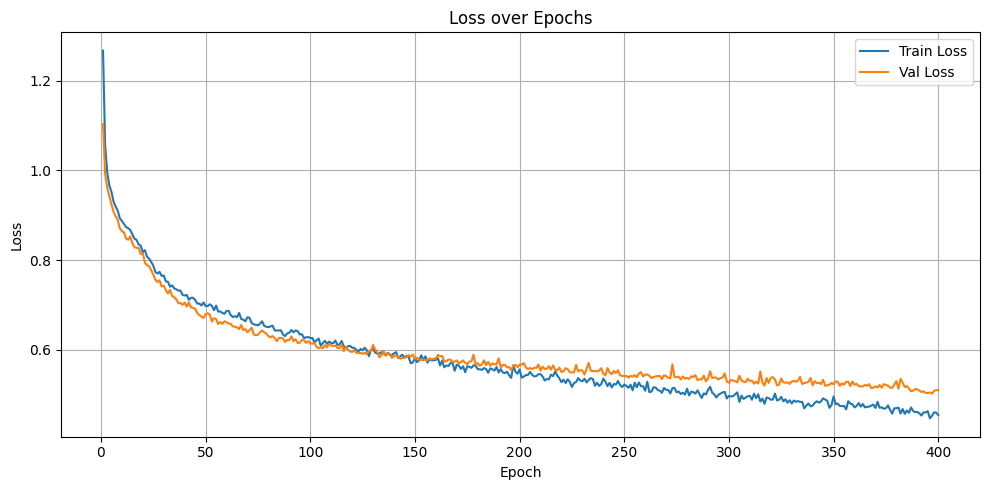

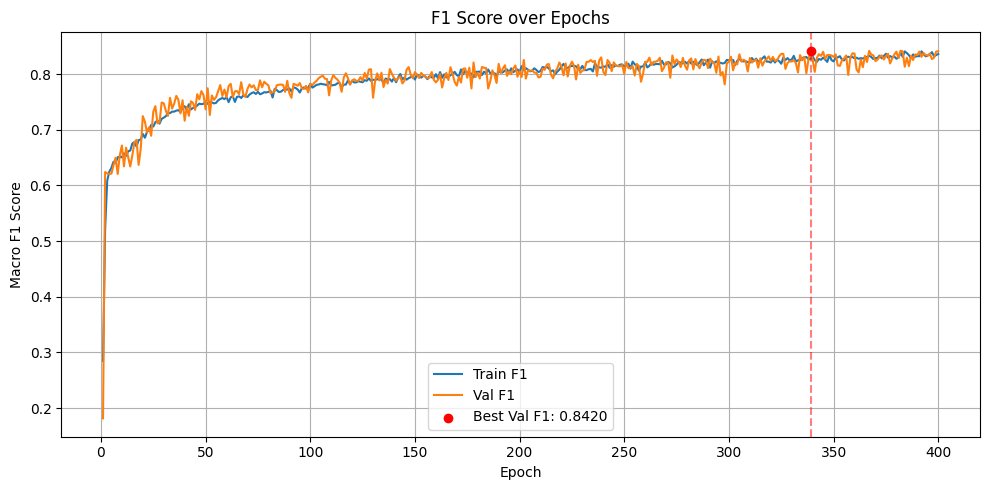

In [53]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, len(train_losses) + 1)

# === Plot Loss ===
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{experiment}_loss_plot.png")

# === Plot F1 ===
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1s, label="Train F1")
plt.plot(epochs, val_f1s, label="Val F1")

# Mark best F1
best_epoch = np.argmax(val_f1s) + 1
best_f1 = val_f1s[best_epoch - 1]
plt.scatter(best_epoch, best_f1, color="red", label=f"Best Val F1: {best_f1:.4f}", zorder=5)
plt.axvline(best_epoch, color="red", linestyle="--", alpha=0.5)

plt.xlabel("Epoch")
plt.ylabel("Macro F1 Score")
plt.title("F1 Score over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{experiment}_f1_plot.png")



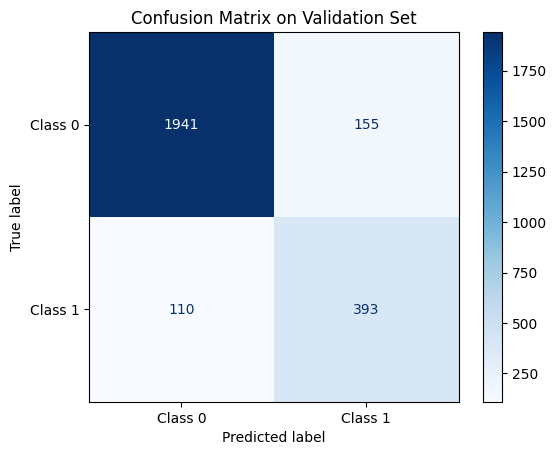

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use model in eval mode
model.load_state_dict(torch.load(f"{experiment}_best_model.pt"))
model.eval()

val_preds, val_targets = [], []

with torch.no_grad():
    for batch in loader_val:
        batch = batch.to(device)
        logits = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        probs = torch.sigmoid(logits).view(-1)
        preds = (probs > 0.5).long().cpu().numpy()
        targets = batch.y.view(-1).long().cpu().numpy()

        val_preds.extend(preds)
        val_targets.extend(targets)

# Confusion matrix
cm = confusion_matrix(val_targets, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Validation Set")
plt.grid(False)

plt.savefig(f"{experiment}_confusion.png")

plt.show()

# Submission

In [56]:
# Create test dataset
dataset_te = EEGDataset(
    clips_te,  # Your test clips variable
    signals_root=DATA_ROOT
    / "test",  # Update this path if your test signals are stored elsewhere
    signal_transform=chosen_transform,  # You can change or remove the signal_transform as needed
    prefetch=False,  # Set to False if prefetching causes memory issues on your compute environment
    return_id=True,  # Return the id of each sample instead of the label
)

In [57]:
from torch_geometric.data import Data
from tqdm import tqdm

# === Convert (x_np, sample_id) to torch_geometric Data objects ===
new_test_dataset = []
test_ids = []

for x_np, sample_id in tqdm(dataset_te, desc="Converting test set"):
    x = torch.tensor(x_np, dtype=torch.float)  # transpose: (354, 19) -> (19, 354)
    dummy_y = torch.tensor([0.0], dtype=torch.float)  # dummy label, not used during inference
    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=dummy_y)
    new_test_dataset.append(graph)
    test_ids.append(sample_id)

dataset_te = new_test_dataset

Converting test set: 100%|██████████| 3614/3614 [00:18<00:00, 197.79it/s]


In [58]:
loader_te = DataLoader(dataset_te, batch_size=2**8, shuffle=False)

In [59]:
import pandas as pd
from tqdm import tqdm

model.load_state_dict(torch.load(f"{experiment}_best_model.pt" ))
model.to(device)
model.eval()

predictions = []

with torch.no_grad():
    for batch in tqdm(loader_te, desc="Predicting"):
        batch = batch.to(device)
        logits = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        probs = torch.sigmoid(logits).view(-1)
        preds = (probs > 0.5).long().tolist()
        predictions.extend(preds)

# === Sort IDs and predictions together by ID using zip + sorted ===
sorted_pairs = zip(test_ids, predictions)
sorted_ids, sorted_preds = zip(*sorted_pairs)

# === Create submission.csv ===
submission = pd.DataFrame({
    "id": sorted_ids,
    "label": sorted_preds
})

submission.to_csv(f"{experiment}_submission.csv", index=False)
print("submission.csv created with", len(submission), "entries.")


Predicting: 100%|██████████| 15/15 [00:00<00:00, 30.21it/s]

submission.csv created with 3614 entries.


In [60]:
!head submission.csv


'head' is not recognized as an internal or external command,
operable program or batch file.


In [61]:
import pandas as pd
import re

# Load broken submission
df = pd.read_csv(f"{experiment}_submission.csv")

# Fix underscores and structure
def clean_id(bad_id):
    # Remove underscores
    no_underscores = bad_id.replace("_", "")
    # Extract parts with regex
    match = re.match(r"([a-z]+)(s\d{3})(t\d{3})(\d+)", no_underscores)
    if not match:
        return bad_id  # fallback
    return f"{match[1]}_{match[2]}_{match[3]}_{match[4]}"

df["id"] = df["id"].apply(clean_id)

# Save fixed file
df.to_csv(f"{experiment}_submission-final.csv", index=False)
print("Final submission.csv is saved!")
!head submission_512batchsize_1000epoch_lr5e-3.csv


Final submission.csv is saved!


'head' is not recognized as an internal or external command,
operable program or batch file.
